# Bayesian filtering: tracking multiple sensors using radio pings

## Load the libraries we need

In [1]:
import numpy as np
from scipy import misc
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import csv
import json
import math
import time
import sys
import os

## Load the data

The data currently exists in a set of JSON files (one for each time window) in the format produced by [tools/get_radio_obs.py](https://github.com/WildflowerSchools/sensei/blob/master/tools/get_radio_obs.py) from the [sensei repository](https://github.com/WildflowerSchools/sensei).

In [2]:
data_json_path = './data/json/'

In [3]:
json_input_files = [x for x in os.listdir(data_json_path) if x.endswith('.json')]

In [4]:
dataframes = []

In [5]:
for json_input_file in json_input_files:
    with open(os.path.join(data_json_path, json_input_file), 'r') as input_fullpath:
        dataframes.append(pd.read_json(input_fullpath))

In [6]:
all_data = pd.concat(dataframes, ignore_index = True)

In [7]:
all_data

local_id local_type         observed_at  remote_id remote_type  rssi
0              8       area 2017-11-28 14:00:00      11061       child   -88
1              8       area 2017-11-28 14:00:00      11060       child   -91
2             12       area 2017-11-28 14:00:00      11060       child   -83
3             13       area 2017-11-28 14:00:00      11067       child   -86
4              9       area 2017-11-28 14:00:00      11067       child   -82
5              9       area 2017-11-28 14:00:00      11060       child   -85
6              9       area 2017-11-28 14:00:00      11061       child   -83
7          11060      child 2017-11-28 14:00:00      11061       child   -71
8          11060      child 2017-11-28 14:00:00      11067       child   -69
9          11062      child 2017-11-28 14:00:00      11067       child   -81
10         11067      child 2017-11-28 14:00:00      11060       child   -69
11         11067      child 2017-11-28 14:00:00      11061       child   -71
12         11061      child 2017-11-28 14:00:00      11060       child   -71
13         11061      child 2017-11-28 14:00:00      11067       child   -70
14          5613    teacher 2017-11-28 14:00:00          9        area   -78
15            11       area 2017-11-28 14:00:00      11062       child   -73
16            11       area 2017-11-28 14:00:00      11061       child   -74
17            11       area 2017-11-28 14:00:00      11060       child   -72
18         11065      child 2017-11-28 14:00:00      11060       child   -69
19         11065      child 2017-11-28 14:00:00      11067       child   -55
20         11066      child 2017-11-28 14:00:00      11062       child   -66
21       1208464   material 2017-11-28 14:00:00      39282       child   -79
22       1208463   material 2017-11-28 14:00:00      11067       child   -77
23         11067      child 2017-11-28 14:00:00      39282       child   -77
24         11060      child 2017-11-28 14:00:00      39282       child   -75
25         39282      child 2017-11-28 14:00:00      11061       child   -53
26         39282      child 2017-11-28 14:00:00      11067       child   -76
27         39282      child 2017-11-28 14:00:00      47422       child   -68
28         39282      child 2017-11-28 14:00:00      11060       child   -75
29         11061      child 2017-11-28 14:00:00      39282       child   -52
...          ...        ...                 ...        ...         ...   ...
108424        11       area 2017-11-28 20:00:00      11060       child   -67
108425        11       area 2017-11-28 20:00:00      11067       child   -73
108426         8       area 2017-11-28 20:00:00       5612     teacher   -89
108427      5612    teacher 2017-11-28 20:00:00      11067       child   -87
108428      5612    teacher 2017-11-28 20:00:00      11060       child   -85
108429      5612    teacher 2017-11-28 20:00:00         12        area   -79
108430   1208463   material 2017-11-28 20:00:00      11067       child   -81
108431     11067      child 2017-11-28 20:00:00    1208463    material   -82
108432     11067      child 2017-11-28 20:00:00    1208471    material   -81
108433     11061      child 2017-11-28 20:00:00    1208471    material   -71
108434   1208471   material 2017-11-28 20:00:00      11067       child   -80
108435   1208471   material 2017-11-28 20:00:00      11060       child   -84
108436   1208471   material 2017-11-28 20:00:00      11061       child   -71
108437        12       area 2017-11-28 20:00:00      62461       child   -75
108438     11060      child 2017-11-28 20:00:00    1208463    material   -82
108439      5612    teacher 2017-11-28 20:00:00    1208464    material   -81
108440   1208464   material 2017-11-28 20:00:00      11060       child   -76
108441     11060      child 2017-11-28 20:00:00    1208464    material   -76
108442     11061      child 2017-11-28 20:00:00    1208464    material   -83
108443      5613    teacher 2017-11-28 20:00:00    1208464    material   -74
1084

## Format and clean up the data

Check the data types that were produced by the auto-conversion algorithms.

In [8]:
all_data.dtypes

local_id                int64
local_type             object
observed_at    datetime64[ns]
remote_id               int64
remote_type            object
rssi                    int64
dtype: object

Looks good, but we probably want to change `local_type` and `remote_type` to categorical variables.

In [9]:
sensor_types = ['child', 'material', 'teacher', 'area']

In [10]:
all_data['local_type'] = pd.Categorical(all_data['local_type'], categories=sensor_types)
all_data['remote_type'] = pd.Categorical(all_data['remote_type'], categories=sensor_types)

Calculate a set of summary statistics for the pings sent by each sensor.

In [11]:
sensor_diagnostics = all_data.groupby('remote_id')['observed_at'].agg(['nunique', 'min', 'max']).rename(
    columns = {'nunique': 'n_times', 'min': 'min_time', 'max': 'max_time'}
)

In [12]:
sensor_diagnostics

n_times            min_time            max_time
remote_id                                                 
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00

Sort by the total number of time windows in which each sensor sent pings.

In [13]:
sensor_diagnostics.sort_values('n_times')

n_times            min_time            max_time
remote_id                                                 
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00

A handful of sensors sent pings in very few time windows (e.g., fewer than 200 time windows out of over 2,000 time windows). Eventually, our algorithms need to robust enough to handle these kinds of situations (e.g., by inferring from the data which sensors are actually present on the mesh). For now, though, we probably want to remove these sensors from the data before doing any analysis.

Sort by the earliest time that each sensor sent pings.

In [14]:
sensor_diagnostics.sort_values('min_time')

n_times            min_time            max_time
remote_id                                                 
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00

A couple of the sensors didn't send any pings for the first hour and a half or so. Similarly, we probably want to remove these sensors from the data before doing any analysis.

Sort by the latest time that each sensor sent pings.

In [15]:
sensor_diagnostics.sort_values('max_time')

n_times            min_time            max_time
remote_id                                                 
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00

One sensor stopped sending pings after 24 minutes and then a punch of sensors started to cut out after a couple of hours. We probably want to remove the first sensor and truncate the entire data set after 16:00 UTC.

Apply these rules to produce a list of the sensors we want to keep in the data.

In [16]:
usable_sensors = sensor_diagnostics[(sensor_diagnostics['n_times'] > 200) &
                                    (sensor_diagnostics['min_time'] < pd.Timestamp('2017-11-28 14:30')) &
                                    (sensor_diagnostics['max_time'] > pd.Timestamp('2017-11-28 16:00'))].index.values.tolist()

In [17]:
usable_sensors

[8L,
 9L,
 10L,
 11L,
 12L,
 13L,
 5612L,
 5613L,
 11060L,
 11061L,
 11065L,
 11066L,
 11067L,
 39282L,
 41582L,
 47422L,
 62459L,
 1208461L,
 1208463L,
 1208464L,
 1208468L,
 1208469L,
 1208471L]

We also want to remove the sensor with entity ID 8. That sensor is in the bathroom in the basement, and its data won't make sense in our current two-dimensional model.

In [18]:
usable_sensors.remove(8)

Subtract our usable sensor list from the overall list of sensors so we can see which sensors we are removing.

In [19]:
set(sensor_diagnostics.index.values.tolist()) - set(usable_sensors)

{8L, 11062L, 31986L, 47423L, 62461L}

These correspond to the problematic sensors we identified above.

Filter out these sensors and remove all data after 16:00 UTC to produce the dataset we will use for all subsequent analysis.

In [20]:
usable_data = all_data[(all_data['remote_id'].isin(usable_sensors)) &
                       (all_data['local_id'].isin(usable_sensors)) &
                       (all_data['observed_at'] <= pd.Timestamp('2017-11-28 16:00'))].reset_index(drop=True)

In [21]:
usable_data

local_id local_type         observed_at  remote_id remote_type  rssi
0            12       area 2017-11-28 14:00:00      11060       child   -83
1            13       area 2017-11-28 14:00:00      11067       child   -86
2             9       area 2017-11-28 14:00:00      11067       child   -82
3             9       area 2017-11-28 14:00:00      11060       child   -85
4             9       area 2017-11-28 14:00:00      11061       child   -83
5         11060      child 2017-11-28 14:00:00      11061       child   -71
6         11060      child 2017-11-28 14:00:00      11067       child   -69
7         11067      child 2017-11-28 14:00:00      11060       child   -69
8         11067      child 2017-11-28 14:00:00      11061       child   -71
9         11061      child 2017-11-28 14:00:00      11060       child   -71
10        11061      child 2017-11-28 14:00:00      11067       child   -70
11         5613    teacher 2017-11-28 14:00:00          9        area   -78
12           11       area 2017-11-28 14:00:00      11061       child   -74
13           11       area 2017-11-28 14:00:00      11060       child   -72
14        11065      child 2017-11-28 14:00:00      11060       child   -69
15        11065      child 2017-11-28 14:00:00      11067       child   -55
16      1208464   material 2017-11-28 14:00:00      39282       child   -79
17      1208463   material 2017-11-28 14:00:00      11067       child   -77
18        11067      child 2017-11-28 14:00:00      39282       child   -77
19        11060      child 2017-11-28 14:00:00      39282       child   -75
20        39282      child 2017-11-28 14:00:00      11061       child   -53
21        39282      child 2017-11-28 14:00:00      11067       child   -76
22        39282      child 2017-11-28 14:00:00      47422       child   -68
23        39282      child 2017-11-28 14:00:00      11060       child   -75
24        11061      child 2017-11-28 14:00:00      39282       child   -52
25        11061      child 2017-11-28 14:00:00      47422       child   -67
26        47422      child 2017-11-28 14:00:00      11065       child   -62
27        47422      child 2017-11-28 14:00:00      39282       child   -68
28           13       area 2017-11-28 14:00:00      47422       child   -88
29        11065      child 2017-11-28 14:00:00      47422       child   -61
...         ...        ...                 ...        ...         ...   ...
40417     11066      child 2017-11-28 16:00:00    1208469    material   -91
40418     62459      child 2017-11-28 16:00:00         11        area   -77
40419     47422      child 2017-11-28 16:00:00         11        area   -73
40420     39282      child 2017-11-28 16:00:00    1208463    material   -70
40421     11067      child 2017-11-28 16:00:00    1208463    material   -85
40422     39282      child 2017-11-28 16:00:00    1208464    material   -73
40423     11060      child 2017-11-28 16:00:00      41582       child   -89
40424     47422      child 2017-11-28 16:00:00    1208471    material   -88
40425     11061      child 2017-11-28 16:00:00    1208471    material   -76
40426     47422      child 2017-11-28 16:00:00      41582       child   -88
40427        12       area 2017-11-28 16:00:00      41582       child   -79
40428   1208471   material 2017-11-28 16:00:00      47422       child   -87
40429     39282      child 2017-11-28 16:00:00      41582       child   -89
40430     62459      child 2017-11-28 16:00:00      11065       child   -64
40431     11061      child 2017-11-28 16:00:00    1208463    material   -84
40432     11065      child 2017-11-28 16:00:00      62459       child   -66
40433     41582      child 2017-11-28 16:00:00    1208463    material   -83
40434   1208471   material 2017-11-28 16:00:00      41582       child   -89
40435     41582      child 2017-11-28 16:00:00         12        area   -80
40436     62459      child 2017-11-28 16:00:00    1208463    material   -84
40437     62459      child 2017-11-28 16:00:00    12084

Extract the list of entity ID's for each type of sensor, because we'll need these in structuring and naming the variables.

In [22]:
child_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'child'].local_id),
                              pd.unique(usable_data[usable_data.remote_type == 'child'].remote_id)).tolist()
material_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'material'].local_id),
                                 pd.unique(usable_data[usable_data.remote_type == 'material'].remote_id)).tolist()
teacher_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'teacher'].local_id),
                                pd.unique(usable_data[usable_data.remote_type == 'teacher'].remote_id)).tolist()
area_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'area'].local_id),
                             pd.unique(usable_data[usable_data.remote_type == 'area'].remote_id)).tolist()

moving_entity_ids = child_entity_ids + material_entity_ids + teacher_entity_ids
fixed_entity_ids = area_entity_ids

entity_ids = moving_entity_ids + fixed_entity_ids

num_child_sensors = len(child_entity_ids)
num_teacher_sensors = len(teacher_entity_ids)
num_material_sensors = len(material_entity_ids)
num_area_sensors = len(area_entity_ids)
num_moving_sensors = len(moving_entity_ids)
num_fixed_sensors = len(fixed_entity_ids)
num_sensors = len(entity_ids)

In [23]:
child_entity_ids

[11060L, 11061L, 11065L, 11066L, 11067L, 39282L, 41582L, 47422L, 62459L]

In [24]:
material_entity_ids

[1208461L, 1208463L, 1208464L, 1208468L, 1208469L, 1208471L]

In [25]:
teacher_entity_ids

[5612L, 5613L]

In [26]:
area_entity_ids

[9L, 10L, 11L, 12L, 13L]

In [27]:
moving_entity_ids

[11060L,
 11061L,
 11065L,
 11066L,
 11067L,
 39282L,
 41582L,
 47422L,
 62459L,
 1208461L,
 1208463L,
 1208464L,
 1208468L,
 1208469L,
 1208471L,
 5612L,
 5613L]

In [28]:
fixed_entity_ids

[9L, 10L, 11L, 12L, 13L]

In [29]:
entity_ids

[11060L,
 11061L,
 11065L,
 11066L,
 11067L,
 39282L,
 41582L,
 47422L,
 62459L,
 1208461L,
 1208463L,
 1208464L,
 1208468L,
 1208469L,
 1208471L,
 5612L,
 5613L,
 9L,
 10L,
 11L,
 12L,
 13L]

Add a new data column with an integer index for time.

In [30]:
usable_data=usable_data.assign(
    t_index = ((usable_data.observed_at - usable_data.observed_at.min())/np.timedelta64(10, 's')).astype(int)
)

Create an array which represents all possible time index values in the observed time span (including time index values with no ping data that therefore don't appear in our data).

In [31]:
t_indices = np.arange(usable_data.t_index.min(), usable_data.t_index.max() + 1)
num_timesteps = len(t_indices)

See if there were any timesteps in which we received no data.

In [32]:
np.setdiff1d(t_indices, usable_data['t_index']).tolist()

[241, 242, 243]

There were three subsequent timesteps in which no ping data was recorded. We already knew this from [earlier analyses](https://wildflowerschools.github.io/ping_statistics/).

Set up a parallel vector of actual timestamps (including timestamps with no ping data that therefore don't appear in our data).

In [33]:
t = pd.date_range(usable_data['observed_at'].min(), usable_data['observed_at'].max(), freq='10S')

## Restructure the data for use in the model

We need to restructure this data into two flat structures. For each pair of sensors that talk to each other, `y_discrete_t` should encode the data for whether a ping was received in each timestep and `y_continuous_t` should encode the data for the measured RSSI of the ping if it was received.

We'll do this in two steps. First, we'll structure the data into an array format which includes all sensors and then we'll extract the subset of sensors that actually communicate and flatten the result.

First, initialize the arrays. For `y_discrete_t`, we'll use 0 to indicate that a ping was received and 1 to indicate that a ping was not received (don't ask). For `y_continuous_t`, we'll convert the integer RSSI values to floats (since we're treating RSSI as a continuous variable) and we'll just enter a 0.0 value for RSSI if no ping was received.

In [34]:
y_discrete_t_all_sensors = np.ones((num_timesteps, num_sensors, num_sensors), dtype='int')
y_continuous_t_all_sensors = np.zeros((num_timesteps, num_sensors, num_sensors), dtype='float')

Step through the data, copying the information into these arrays.

In [35]:
for row in range(usable_data.shape[0]):
    y_discrete_t_all_sensors[usable_data.iloc[row, 6],
                             entity_ids.index(usable_data.iloc[row, 3]),
                             entity_ids.index(usable_data.iloc[row, 0])] = 0
    y_continuous_t_all_sensors[usable_data.iloc[row, 6],
                               entity_ids.index(usable_data.iloc[row, 3]),
                               entity_ids.index(usable_data.iloc[row, 0])] = usable_data.iloc[row, 5]

Apply some basic sanity checks.

In [36]:
np.sum(y_discrete_t_all_sensors == 0)

40447

In [37]:
np.sum(y_continuous_t_all_sensors != 0.0)

40447

In [38]:
len(usable_data)

40447

Now we need to extract and flatten the subset of variables that correspond to the pairs of sensors for which we actually record data. We'll do this by creating a boolean mask with `True` in the positions that we want to extract. First we initialize the mask (with the same shape as the arrays above).

In [39]:
extract_y_variables_mask = np.full((num_sensors, num_sensors), True)

Sensors don't send pings to themselves.

In [40]:
np.fill_diagonal(extract_y_variables_mask, False)

We don't store pings from material sensors to other material sensors.

In [41]:
extract_y_variables_mask[num_child_sensors:(num_child_sensors+num_material_sensors),
                        num_child_sensors:(num_child_sensors+num_material_sensors)] = False

We don't store pings from teacher sensors to other teacher sensors.

In [42]:
extract_y_variables_mask[(num_child_sensors+num_material_sensors):num_moving_sensors,
                        (num_child_sensors+num_material_sensors):num_moving_sensors] = False

We don't store pings from area sensors to other area sensors.

In [43]:
extract_y_variables_mask[num_moving_sensors:,
                        num_moving_sensors:] = False

We don't store pings from material sensors to area sensors (and _vice versa_).

In [44]:
extract_y_variables_mask[num_child_sensors:(num_child_sensors+num_material_sensors),
                        num_moving_sensors:] = False
extract_y_variables_mask[num_moving_sensors:,
                         num_child_sensors:(num_child_sensors+num_material_sensors)] = False

Define a function which uses this mask to extract the subset of valid $\mathbf{Y}$ variables and flattens them into a one-dimensional array.

In [45]:
def extract_y_variables(a):
    return a[..., extract_y_variables_mask]

Use this function to extract our variables.

In [46]:
y_discrete_t = extract_y_variables(y_discrete_t_all_sensors)
y_continuous_t = extract_y_variables(y_continuous_t_all_sensors)

Apply our sanity checks again.

In [47]:
np.sum(y_discrete_t == 0)

40447

In [48]:
np.sum(y_continuous_t != 0.0)

40447

In [49]:
len(usable_data)

40447

## Define variable names

At many points below, we'll need the names of various $\mathbf{X}$ and $\mathbf{Y}$ variables so we can display results in different formats.

### Define the names of the sensors and the spatial dimensions

Define the names of the sensors

In [50]:
child_sensor_names = ['Child sensor {}'.format(id) for id in child_entity_ids]
material_sensor_names = ['Material sensor {}'.format(id) for id in material_entity_ids]
teacher_sensor_names = ['Teacher sensor {}'.format(id) for id in teacher_entity_ids]
area_sensor_names = ['Area sensor {}'.format(id) for id in area_entity_ids]
    
moving_sensor_names = child_sensor_names + material_sensor_names + teacher_sensor_names
fixed_sensor_names = area_sensor_names
sensor_names = moving_sensor_names + fixed_sensor_names

Define the names of the spatial dimensions

In [51]:
dimension_names = [
    '$l$',
    '$w$'
]

Define the number of spatial dimensions.

In [52]:
num_dimensions = len(dimension_names)

### Define the names of the $\mathbf{X}$ variables

First, we define the names of the discrete $\mathbf{X}$ variables.

For now, we have no discrete $\mathbf{X}$ variables. In the future, we may include things like discrete variables for whether or not a sensor is present on the mesh, but for now, this is just a placeholder.

In [53]:
x_discrete_names = []

Now we want to define the names of the continuous $\mathbf{X}$ variables. We approach this similarly to how we extracted the $\mathbf{Y}$ variables from the data above. First, we define a matrix with all of the sensors down one axis and all of the spatial dimensions across the other axis Then we use a boolean mask to extract and flatten those quantities that refer to the state variables we are actually tracking (the moving sensors).

Construct the matrix of all possible continuous $\mathbf{X}$ variable names.

In [54]:
sensor_position_name_matrix = [['{} {} position'.format(sensor_name, dimension_name)
                                for dimension_name in dimension_names]
                               for sensor_name in sensor_names]

Define a boolean mask with `True` values in the positions of the names we want to extract.

In [55]:
extract_x_variables_mask = np.full((num_sensors, num_dimensions), True)

In [56]:
extract_x_variables_mask[num_moving_sensors:,:] = False

Define a function that uses this mask to extract and flatten the $\mathbf{X}$ variables.

In [57]:
def extract_x_variables(a):
    return a[...,extract_x_variables_mask]

Use this function to extract the names of the continuous $\mathbf{X}$ variables. Note that this function is designed to work with `numpy` arrays (because we're going to be using it on numbers), so we have to convert the input to an array and then convert the result back to a list when we're done (since lists are more appropriate for strings).

In [58]:
x_continuous_names = extract_x_variables(np.array(sensor_position_name_matrix)).tolist()

### Define the names of the $\mathbf{Y}$ variables

We can use the machinery we built above to extract the $\mathbf{Y}$ variable names from a matrix of all possible sensor pairs.

Construct the matrix of all possible discrete $\mathbf{Y}$ variable names.

In [59]:
y_discrete_name_matrix = [['Status of ping from {} to {}'.format(sending_sensor_name, receiving_sensor_name)
                           for receiving_sensor_name in sensor_names]
                          for sending_sensor_name in sensor_names]

Construct the matrix of all possible continuous $\mathbf{Y}$ variable names.

In [60]:
y_continuous_name_matrix = [['RSSI of ping from {} to {}'.format(sending_sensor_name, receiving_sensor_name)
                             for receiving_sensor_name in sensor_names]
                            for sending_sensor_name in sensor_names]

Use our matrix to extract a flattened list of allowed variable names.

In [61]:
y_discrete_names = extract_y_variables(np.array(y_discrete_name_matrix)).tolist()

In [62]:
y_continuous_names = extract_y_variables(np.array(y_continuous_name_matrix)).tolist()

Define the names of the different ping statuses.

In [63]:
ping_status_names = [
    'Received',
    'Not received'
]

Define constants for the number of $\mathbf{X}$ variables, the number of $\mathbf{Y}$ variables, and the number of ping statuses (since we'll need these in a bunch of places).

In [64]:
num_x_discrete_vars = len(x_discrete_names)
num_x_continuous_vars = len(x_continuous_names)

num_y_discrete_vars = len(y_discrete_names)
num_y_continuous_vars = len(y_continuous_names)

num_ping_statuses = len(ping_status_names)

Print out all of these variables to make sure they are what we expect.

In [65]:
x_discrete_names

[]

In [66]:
x_continuous_names

['Child sensor 11060 $l$ position',
 'Child sensor 11060 $w$ position',
 'Child sensor 11061 $l$ position',
 'Child sensor 11061 $w$ position',
 'Child sensor 11065 $l$ position',
 'Child sensor 11065 $w$ position',
 'Child sensor 11066 $l$ position',
 'Child sensor 11066 $w$ position',
 'Child sensor 11067 $l$ position',
 'Child sensor 11067 $w$ position',
 'Child sensor 39282 $l$ position',
 'Child sensor 39282 $w$ position',
 'Child sensor 41582 $l$ position',
 'Child sensor 41582 $w$ position',
 'Child sensor 47422 $l$ position',
 'Child sensor 47422 $w$ position',
 'Child sensor 62459 $l$ position',
 'Child sensor 62459 $w$ position',
 'Material sensor 1208461 $l$ position',
 'Material sensor 1208461 $w$ position',
 'Material sensor 1208463 $l$ position',
 'Material sensor 1208463 $w$ position',
 'Material sensor 1208464 $l$ position',
 'Material sensor 1208464 $w$ position',
 'Material sensor 1208468 $l$ position',
 'Material sensor 1208468 $w$ position',
 'Material sensor 120846

In [67]:
y_discrete_names

['Status of ping from Child sensor 11060 to Child sensor 11061',
 'Status of ping from Child sensor 11060 to Child sensor 11065',
 'Status of ping from Child sensor 11060 to Child sensor 11066',
 'Status of ping from Child sensor 11060 to Child sensor 11067',
 'Status of ping from Child sensor 11060 to Child sensor 39282',
 'Status of ping from Child sensor 11060 to Child sensor 41582',
 'Status of ping from Child sensor 11060 to Child sensor 47422',
 'Status of ping from Child sensor 11060 to Child sensor 62459',
 'Status of ping from Child sensor 11060 to Material sensor 1208461',
 'Status of ping from Child sensor 11060 to Material sensor 1208463',
 'Status of ping from Child sensor 11060 to Material sensor 1208464',
 'Status of ping from Child sensor 11060 to Material sensor 1208468',
 'Status of ping from Child sensor 11060 to Material sensor 1208469',
 'Status of ping from Child sensor 11060 to Material sensor 1208471',
 'Status of ping from Child sensor 11060 to Teacher sensor 5

In [68]:
y_continuous_names

['RSSI of ping from Child sensor 11060 to Child sensor 11061',
 'RSSI of ping from Child sensor 11060 to Child sensor 11065',
 'RSSI of ping from Child sensor 11060 to Child sensor 11066',
 'RSSI of ping from Child sensor 11060 to Child sensor 11067',
 'RSSI of ping from Child sensor 11060 to Child sensor 39282',
 'RSSI of ping from Child sensor 11060 to Child sensor 41582',
 'RSSI of ping from Child sensor 11060 to Child sensor 47422',
 'RSSI of ping from Child sensor 11060 to Child sensor 62459',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208461',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208463',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208464',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208468',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208469',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208471',
 'RSSI of ping from Child sensor 11060 to Teacher sensor 5612',
 'RSSI of ping from Chil

In [69]:
num_x_discrete_vars

0

In [70]:
num_x_continuous_vars

34

In [71]:
num_y_discrete_vars

350

In [72]:
num_y_continuous_vars

350

In [73]:
num_ping_statuses

2

## Explore the data

We want to do some basic data exploration to inform the probability models we will use for the particle filter.

### Ping success rate

First, we calculate the ping success rate for each pair of sensors.

In [74]:
ping_success_rate = pd.DataFrame.from_items([
    ('y_discrete_name', y_discrete_names),
    ('success_rate', np.sum(y_discrete_t == 0, axis=0)/float(num_timesteps))
])

In [75]:
pd.set_option('display.max_colwidth', -1)

In [76]:
ping_success_rate

y_discrete_name  \
0    Status of ping from Child sensor 11060 to Child sensor 11061        
1    Status of ping from Child sensor 11060 to Child sensor 11065        
2    Status of ping from Child sensor 11060 to Child sensor 11066        
3    Status of ping from Child sensor 11060 to Child sensor 11067        
4    Status of ping from Child sensor 11060 to Child sensor 39282        
5    Status of ping from Child sensor 11060 to Child sensor 41582        
6    Status of ping from Child sensor 11060 to Child sensor 47422        
7    Status of ping from Child sensor 11060 to Child sensor 62459        
8    Status of ping from Child sensor 11060 to Material sensor 1208461   
9    Status of ping from Child sensor 11060 to Material sensor 1208463   
10   Status of ping from Child sensor 11060 to Material sensor 1208464   
11   Status of ping from Child sensor 11060 to Material sensor 1208468   
12   Status of ping from Child sensor 11060 to Material sensor 1208469   
13   Status of ping from Child sensor 11060 to Material sensor 1208471   
14   Status of ping from Child sensor 11060 to Teacher sensor 5612       
15   Status of ping from Child sensor 11060 to Teacher sensor 5613       
16   Status of ping from Child sensor 11060 to Area sensor 9             
17   Status of ping from Child sensor 11060 to Area sensor 10            
18   Status of ping from Child sensor 11060 to Area sensor 11            
19   Status of ping from Child sensor 11060 to Area sensor 12            
20   Status of ping from Child sensor 11060 to Area sensor 13            
21   Status of ping from Child sensor 11061 to Child sensor 11060        
22   Status of ping from Child sensor 11061 to Child sensor 11065        
23   Status of ping from Child sensor 11061 to Child sensor 11066        
24   Status of ping from Child sensor 11061 to Child sensor 11067        
25   Status of ping from Child sensor 11061 to Child sensor 39282        
26   Status of ping from Child sensor 11061 to Child sensor 41582        
27   Status of ping from Child sensor 11061 to Child sensor 47422        
28   Status of ping from Child sensor 11061 to Child sensor 62459        
29   Status of ping from Child sensor 11061 to Material sensor 1208461   
..                                                                 ...   
320  Status of ping from Area sensor 11 to Child sensor 11066            
321  Status of ping from Area sensor 11 to Child sensor 11067            
322  Status of ping from Area sensor 11 to Child sensor 39282            
323  Status of ping from Area sensor 11 to Child sensor 41582            
324  Status of ping from Area sensor 11 to Child sensor 47422            
325  Status of ping from Area sensor 11 to Child sensor 62459            
326  Status of ping from Area sensor 11 to Teacher sensor 5612           
327  Status of ping from Area sensor 11 to Teacher sensor 5613           
328  Status of ping from Area sensor 12 to Child sensor 11060            
329  Status of ping from Area sensor 12 to Child sensor 11061            
330  Status of ping from Area sensor 12 to Child sensor 11065            
331  Status of ping from Area sensor 12 to Child sensor 11066            
332  Status of ping from Area sensor 12 to Child sensor 11067            
333  Status of ping from Area sensor 12 to Child sensor 39282            
334  Status of ping from Area sensor 12 to Child sensor 41582            
335  Status of ping from Area sensor 12 to Child sensor 47422            
336  Status of ping from Area sensor 12 to Child sensor 62459            
337  Status of ping from Area sensor 12 to Teacher sensor 5612           
338  Status of ping from Area sensor 12 to Teacher sensor 5613           
339  Status of ping from Area sensor 13 to Child sensor 11060            
340  Status of ping from Area sensor 13 to Child sensor 11061            
341  Status of ping from Area sensor 13 to Child sensor 11065            
342  Status of ping from Area sensor 13 to Child sensor 110

It looks like most sensor pairs have a success rate below 30%. A few have no pings recorded at all. Calculate the median success rate across all pairs.

In [77]:
ping_success_rate['success_rate'].median()

0.13522884882108183

Plot a histogram

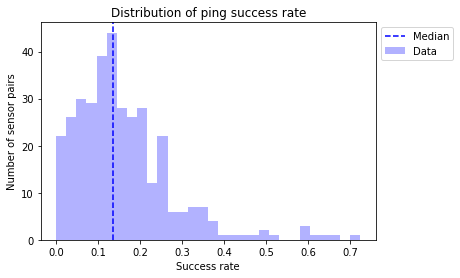

In [78]:
plt.hist(ping_success_rate['success_rate'],
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(ping_success_rate['success_rate'].median(),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a rough check on our data restructuring above, we can run the same histogram from the original dataframe. Note that this will omit the handful of pairs with no ping data, but that will only affect the far left side of the chart.

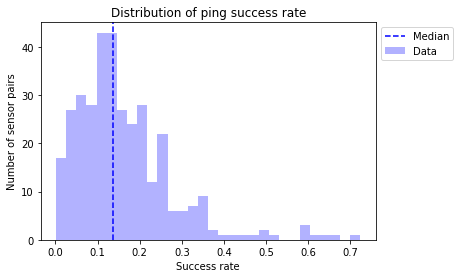

In [79]:
ping_count = usable_data.groupby(['remote_id', 'local_id']).agg({'observed_at': 'nunique'}).rename(columns={'observed_at': 'N'})
ping_count['N'] = ping_count['N']/num_timesteps
ping_count = ping_count.rename(columns={'N': 'success_rate'})
plt.hist(ping_count['success_rate'],
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(ping_count['success_rate'].median(),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

We don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median success rate (about 13.5%) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

### Signal strength

Now we want to look at the distribution of measured RSSI values, but we need to take care to remove the zero values where no ping was received.

In [80]:
measured_rssi_values = y_continuous_t[y_continuous_t != 0.0]

In [81]:
measured_rssi_values.shape

(40447L,)

In [82]:
np.median(measured_rssi_values)

-80.0

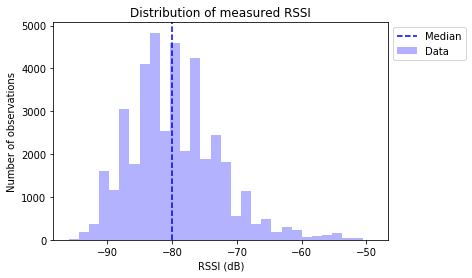

In [83]:
plt.hist(measured_rssi_values,
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(np.median(measured_rssi_values),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a rough check on our data restructuring above, we can run the same histogram from the original dataframe.

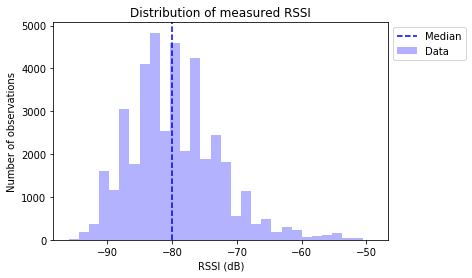

In [84]:
plt.hist(usable_data['rssi'],
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(usable_data['rssi'].median(),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Again, we don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median measured RSSI value (about -80 dB) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

## Create the probability models

The particle filter takes three probability models as inputs: the initial state model $f(\mathbf{X}_0)$, the transition model $f(\mathbf{X}_t | \mathbf{X}_{t-1})$, and the sensor response model $f(\mathbf{Y} | \mathbf{X})$.

### Initial state model

Define  the initial state model $f(\mathbf{X}_0)$. For both the particle filter and to generate simulated data, we need this function in the form of a sampling function that generates samples of the initial state $\mathbf{X}_0$.

For the current problem, we assume that the sensors are initially distributed uniformly throughout the room.

First, we need to define the boundaries of the room. We estimate these very roughly from the floor plan, converting feet to meters.

In [85]:
feet_to_meters = 12*2.54/100

In [86]:
room_size = np.array([(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 2.0)*feet_to_meters,
                      (11.0 + 9.0/12.0)*feet_to_meters])

In [87]:
room_size

array([ 20.0406,   3.5814])

Define a function that generates samples of the initial state $\mathbf{X}_0$.

In [88]:
def x_initial_sample(num_samples=1):
    x_discrete_initial_sample = np.array([])
    x_continuous_initial_sample = np.squeeze(extract_x_variables(np.random.uniform(high=np.tile(room_size,
                                                                                                (num_sensors, 1)),
                                                                                   size=(num_samples,
                                                                                         num_sensors,
                                                                                         num_dimensions))))
    return x_discrete_initial_sample, x_continuous_initial_sample

Generate 1,000 samples and check that they have the properties we expect.

In [89]:
time_start = time.clock()
x_discrete_initial_samples, x_continuous_initial_samples = x_initial_sample(1000)
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.00307712262581


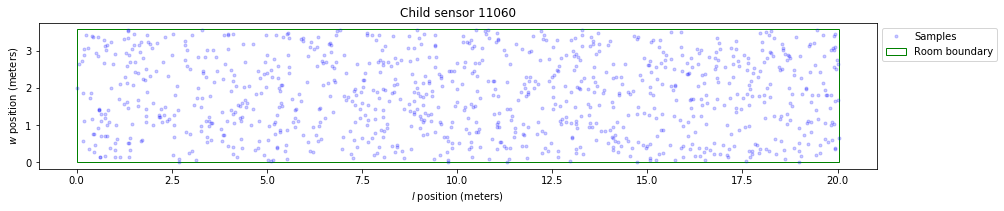

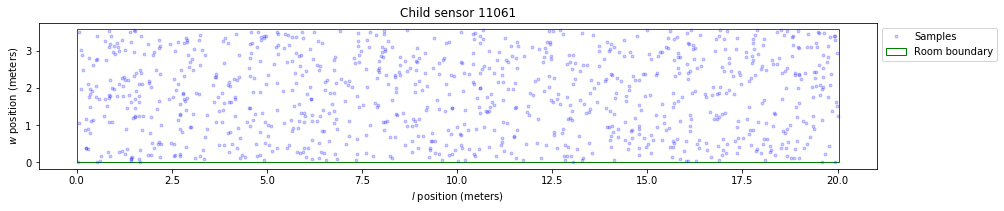

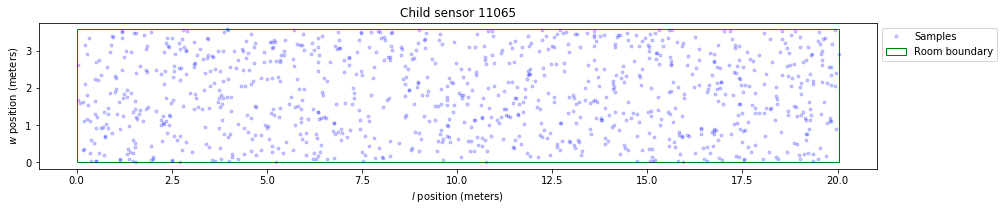

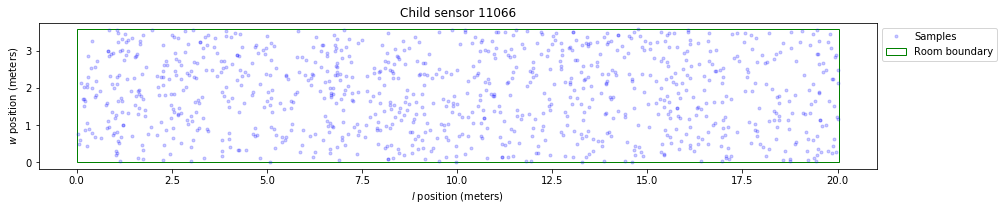

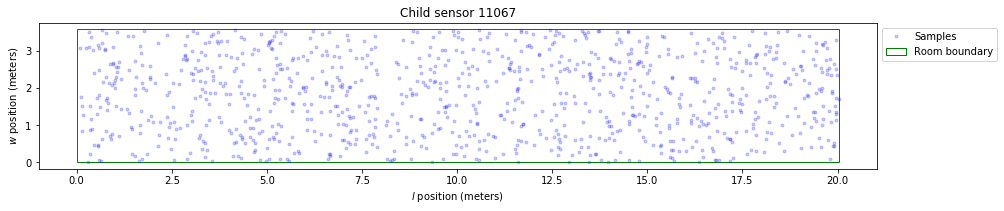

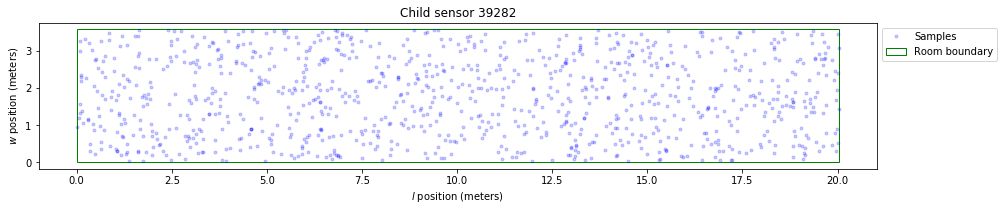

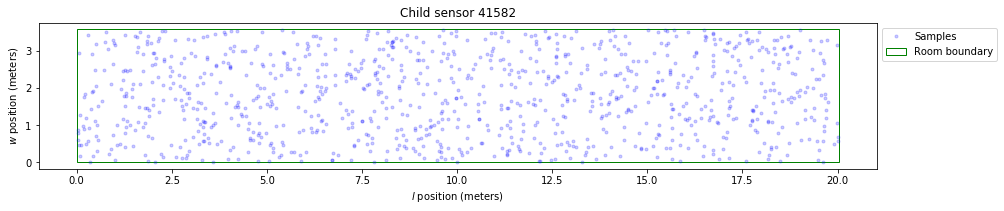

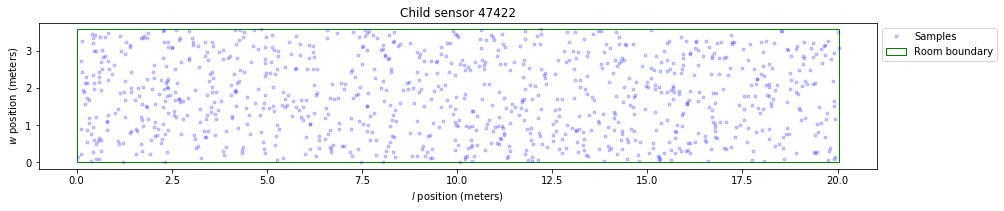

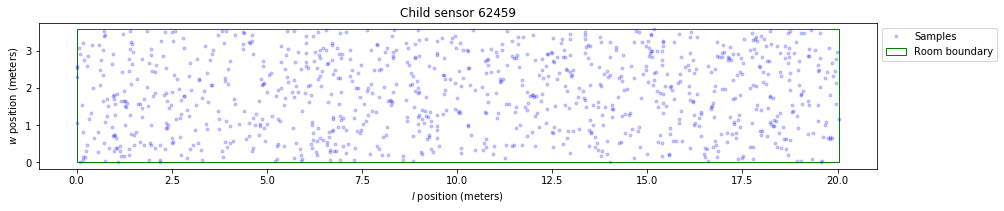

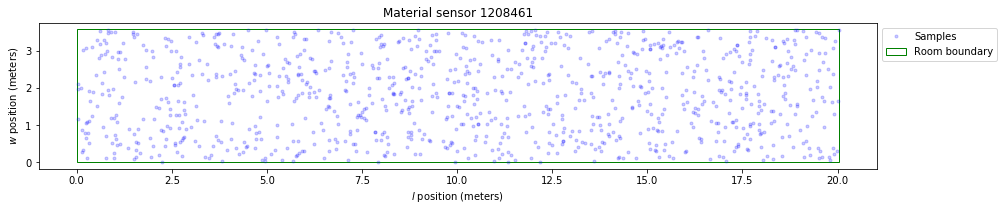

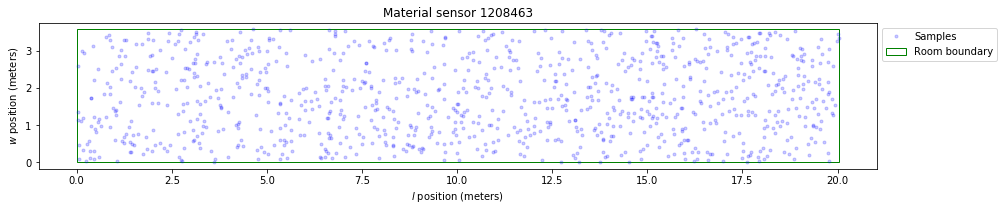

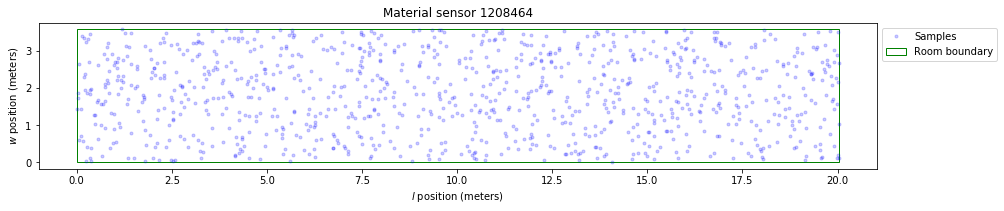

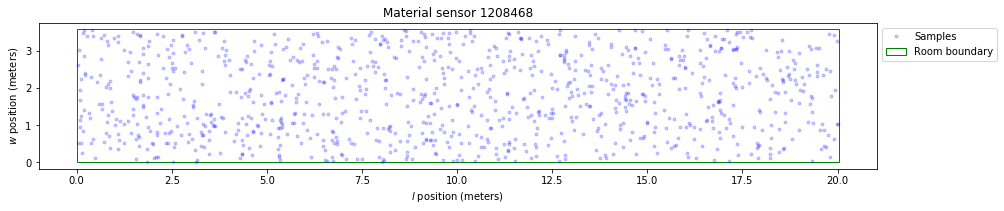

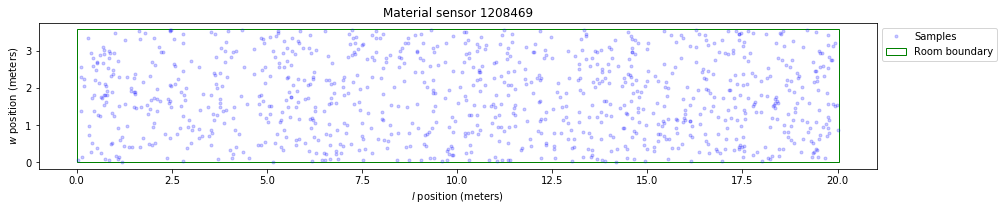

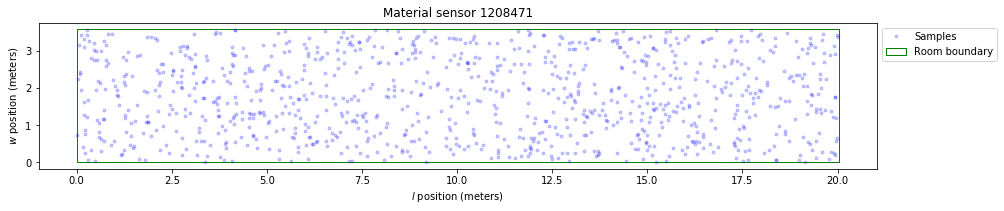

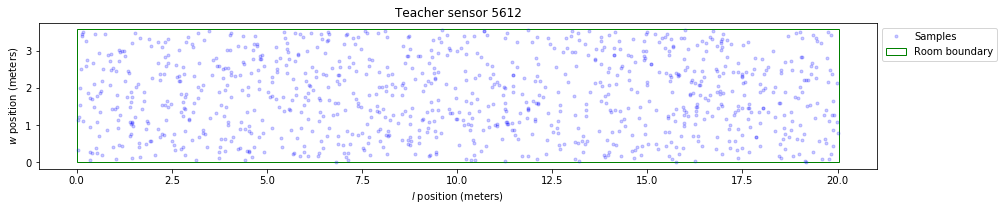

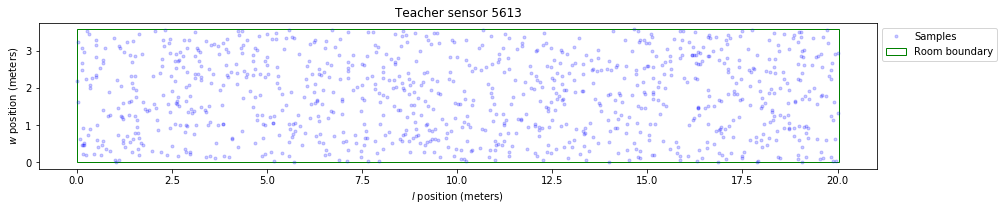

In [90]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(num_moving_sensors):
    plt.plot(x_continuous_initial_samples[:,sensor_index*2],
             x_continuous_initial_samples[:,sensor_index*2 + 1],
             'b.',
             alpha = 0.2,
             label="Samples")
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(dimension_names[1]))
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

### Transition model

Define the transition model $f(\mathbf{X}_t |\mathbf{X}_{t-1})$. For both the particle filter and to generate simulated data, we need this function in the form of a sampling function that generates samples of the state $\mathbf{X}_t$ given $\mathbf{X}_{t-1}$. 

For the current problem, we assume that moving sensors execute a simple two-dimensional random walk. For now, we even ignore the boundaries of the room.

Define the drift distance (in meters) from one timestep to the next. For now, this is really just a placholder. With a fule 10 seconds between timesteps, we really need to rethink our motion model.

In [91]:
moving_sensor_drift = 1.0 # Just a placeholder for now. With 10 seconds between timesteps, we need to rethink our motion model

Define a function that generates samples of $\mathbf{X}_t$, given $\mathbf{X}_{t-1}$.

In [92]:
def x_bar_x_prev_sample(x_discrete_prev, x_continuous_prev):
    x_discrete_bar_x_prev_sample = np.array([])
    x_continuous_bar_x_prev_sample = stats.truncnorm.rvs(a=(np.zeros(num_x_continuous_vars) - x_continuous_prev)/moving_sensor_drift,
                                                         b=(np.tile(room_size, num_x_continuous_vars/2) - x_continuous_prev)/moving_sensor_drift,
                                                         loc=x_continuous_prev,
                                                         scale=moving_sensor_drift)
    return x_discrete_bar_x_prev_sample, x_continuous_bar_x_prev_sample

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions below.

In [93]:
test_x_discrete_value, test_x_continuous_value = x_initial_sample()

Generate 1,000 samples for $\mathbf{X}_t$ (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [94]:
time_start = time.clock()
x_discrete_bar_x_prev_samples, x_continuous_bar_x_prev_samples = x_bar_x_prev_sample(np.array([]),
                                                                                     np.tile(test_x_continuous_value,
                                                                                             (1000,1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0149448660863


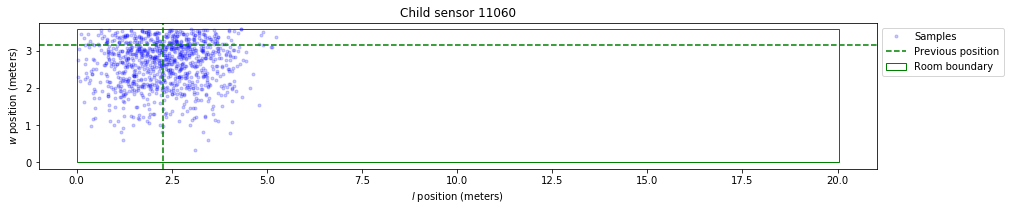

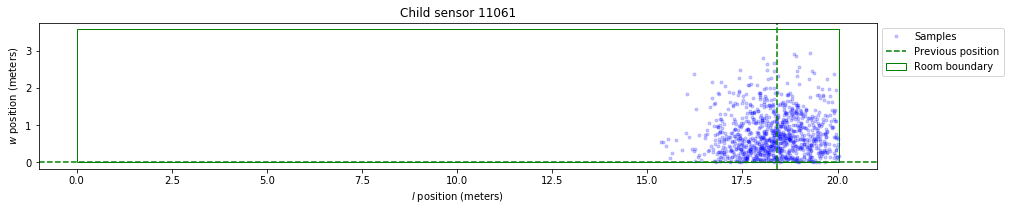

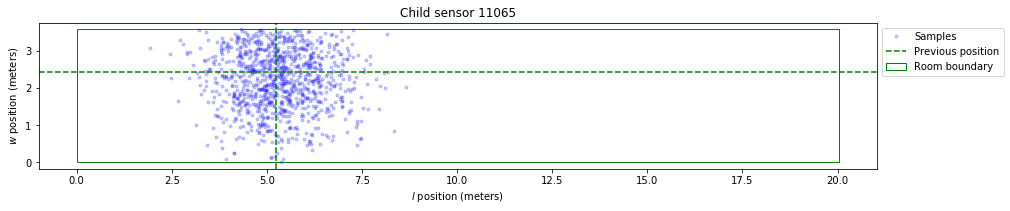

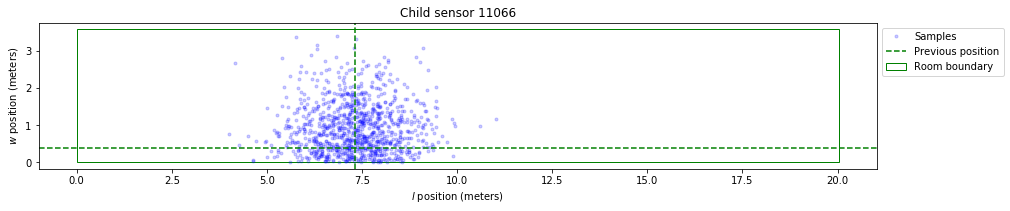

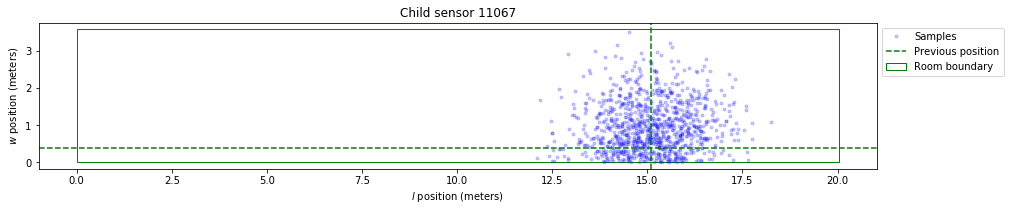

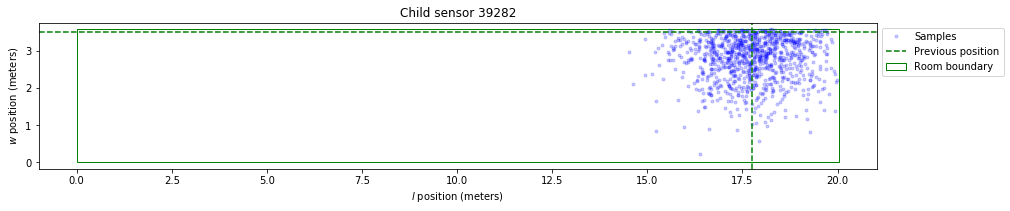

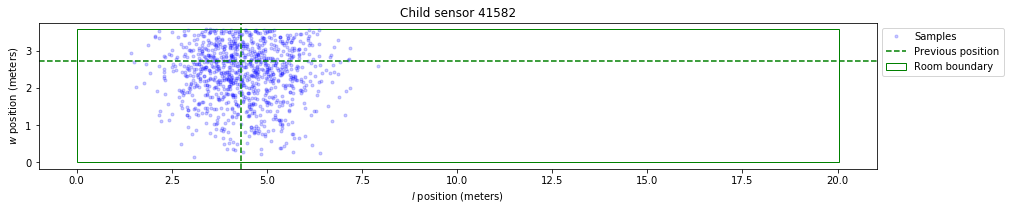

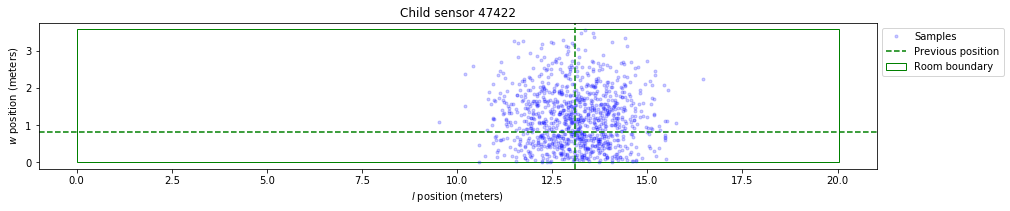

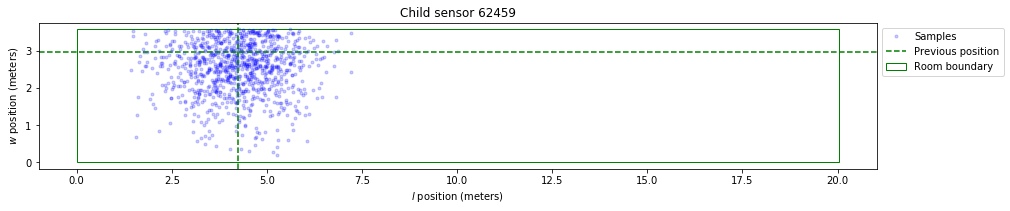

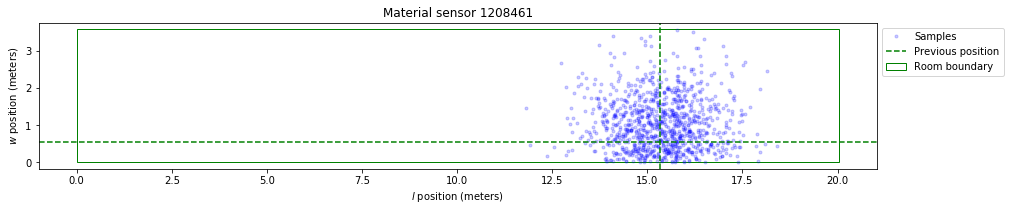

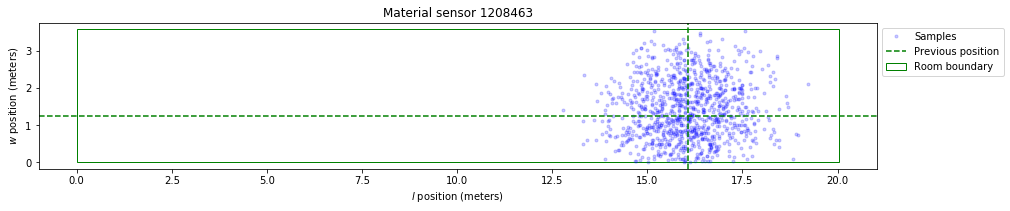

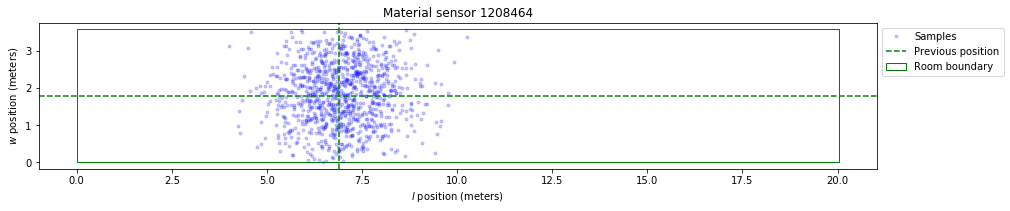

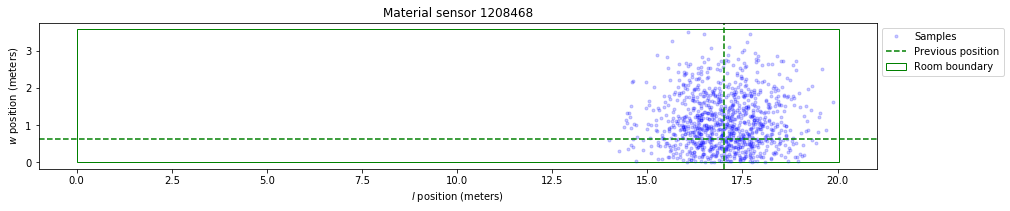

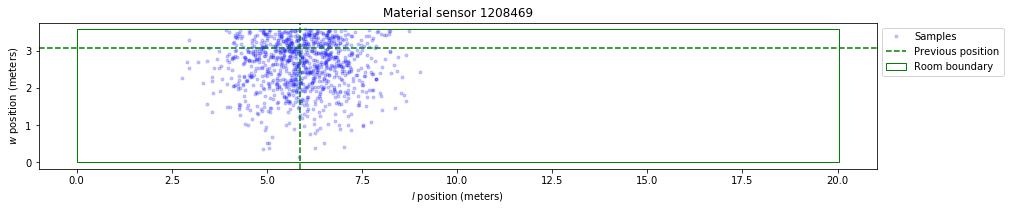

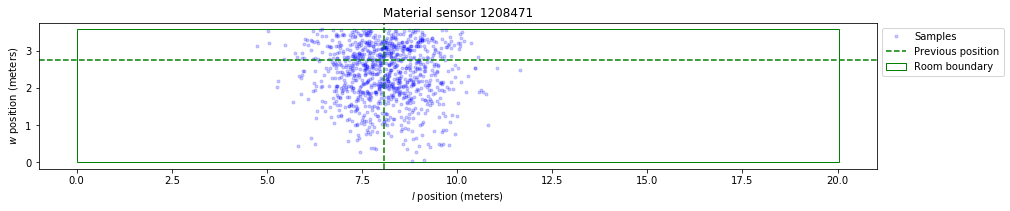

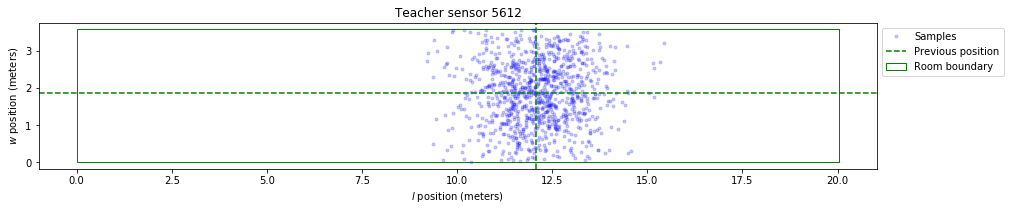

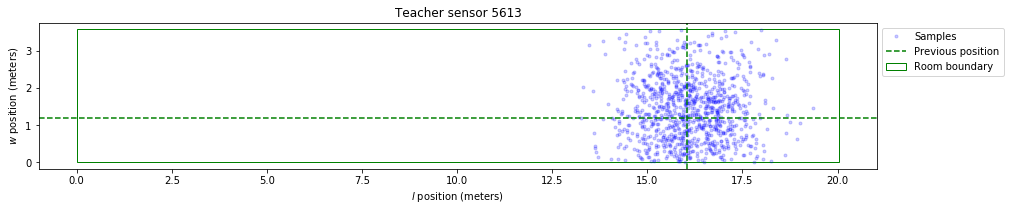

In [95]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(num_moving_sensors):
    plt.plot(x_continuous_bar_x_prev_samples[:,sensor_index*2],
             x_continuous_bar_x_prev_samples[:,sensor_index*2 + 1],
             'b.',
             alpha=0.2,
            label='Samples')
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(dimension_names[1]))
    plt.axvline(x=test_x_continuous_value[sensor_index*2],
                linestyle='dashed',
                color='green',
                label='Previous position')
    plt.axhline(y=test_x_continuous_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

### Sensor response model

Define the sensor response model $f(\mathbf{Y}_t |\mathbf{X}_{t})$. To generate simulated data, we need this function in the form of a sampling function that generates samples of the sensor values $\mathbf{Y}_t$ given the state $\mathbf{X}_{t}$. For the particle filter, we need this function in the form of a (log) probability density $f(\mathbf{Y}_t |\mathbf{X}_{t})$. We start with the sampling function.  

#### Produce samples of $\mathbf{Y}$ given $\mathbf{X}$

Define the positions of the fixed sensors. Here are the names of the fixed sensors, taken from the sensor mappings on the server.

In [96]:
pd.DataFrame.from_items([
    ('fixed_sensor_names', fixed_sensor_names),
    ('tc_ids', [8,2,3,4,5]),
    ('area_name', ['Dishwashing', 'Map Cabinet', 'Art Shelf', 'Golden Beads Area', 'Snack Table'])
])

fixed_sensor_names  tc_ids          area_name
0  Area sensor 9      8       Dishwashing      
1  Area sensor 10     2       Map Cabinet      
2  Area sensor 11     3       Art Shelf        
3  Area sensor 12     4       Golden Beads Area
4  Area sensor 13     5       Snack Table

Here are the rough positions of the fixed sensors, taken from the notes we made when we installed.

In [97]:
fixed_sensor_positions = np.array ([[(19.0 + 4.0/12.0 + 15.0/12.0 + 2.0)*feet_to_meters,
                                     (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(2.0)*feet_to_meters,
                                    (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 1.0)*feet_to_meters,
                                    (3.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 15.0)*feet_to_meters,
                                    (1.0)*feet_to_meters],
                                    [(19.0 + 4.0/12.0 + 15.0/12.0 +3.0)*feet_to_meters,
                                    (3.0)*feet_to_meters]])

In [98]:
fixed_sensor_positions

array([[  6.8834,   3.2766],
       [  0.6096,   3.2766],
       [ 19.7358,   0.9144],
       [ 10.8458,   0.3048],
       [  7.1882,   0.9144]])

Define a function that returns the positions of all of the sensors (including the fixed sensors) given a value for $\mathbf{X}$.

In [99]:
def sensor_positions(x_continuous):
    return np.concatenate((x_continuous.reshape(x_continuous.shape[:-1] + (num_moving_sensors, num_dimensions)),
                           np.broadcast_to(fixed_sensor_positions,
                                           x_continuous.shape[:-1] + fixed_sensor_positions.shape)),
                           axis=-2)

Define a function that returns the distances between the sensors that we are actually tracking (in the same order as `y_names`) given the positions of all of the sensors.

In [100]:
def distances(sensor_positions):
    return extract_y_variables(np.linalg.norm(np.subtract(sensor_positions[...,np.newaxis,:,:],
                                                          sensor_positions[...,:,np.newaxis,:]),
                                              axis = -1))

For the discrete sensor variables that record the status of the pings, we model the likelihood of receiving the ping as declining exponentially with distance. This roughly mirrors what we see in our real test data. First, we define a function that returns the probability of the two ping statuses (received or not received), given the distance between two sensors.

In [101]:
receive_probability_zero_distance = 1.0 # Assume that we hear 100% of pings if sensors are right next to each other
reference_distance = 10.0 # Aproximately half the length of the classroom; approximately the median inter-sensor distance
receive_probability_reference_distance = 0.135 # Approximately the median ping success rate from data above
scale_factor = reference_distance/np.log(receive_probability_reference_distance/receive_probability_zero_distance)

In [102]:
def ping_status_probabilities(distance):
    receive_probability=receive_probability_zero_distance*np.exp(distance/scale_factor)
    return np.stack((receive_probability, 1 - receive_probability), axis=-1)

Plot this function to make sure it has the properties we expect.

In [103]:
distance_range_min = 0.5
distance_range_max = 2*np.linalg.norm(room_size)

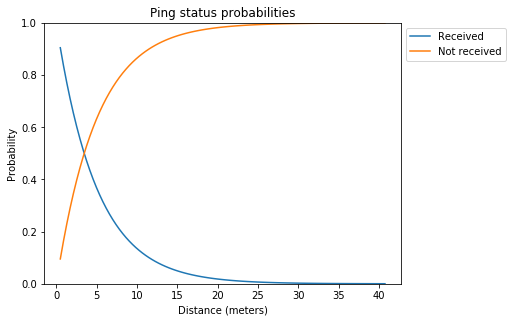

In [104]:
distance_range = np.linspace(distance_range_min, distance_range_max, 100)
ping_status_probabilities_range = ping_status_probabilities(distance_range)
for ping_status_index in range(num_ping_statuses):
    plt.plot(distance_range,
             ping_status_probabilities_range[:, ping_status_index],
             label=ping_status_names[ping_status_index])
plt.ylim(0,1)
plt.xlabel('Distance (meters)')
plt.ylabel('Probability')
plt.title('Ping status probabilities')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Define a function that returns samples of the ping statuses for the sensors we are tracking given the distances between the sensors we are tracking.

In [105]:
def ping_status_samples(distances):
    return np.apply_along_axis(lambda p_array: np.random.choice(len(p_array), p=p_array),
                               axis=-1,
                               arr=ping_status_probabilities(distances))

Put these functions together to produce a function that returns samples of the discrete $\mathbf{Y}$ variables (the status of all of the pings), given a value of $\mathbf{X}$ (the positions of all of the sensors).

In [106]:
def y_discrete_bar_x_sample(x_discrete, x_continuous):
    return ping_status_samples(distances(sensor_positions(x_continuous)))

Generate 1,000 samples (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [107]:
time_start = time.clock()
y_discrete_bar_x_samples = y_discrete_bar_x_sample(np.tile(test_x_discrete_value, (1000,1)),
                                                   np.tile(test_x_continuous_value, (1000,1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 9.59564338828


In [108]:
distances_test_x_continuous_value = distances(sensor_positions(test_x_continuous_value))

Plot the results for 10 randomly chosen discrete $\mathbf{Y}$ variables.

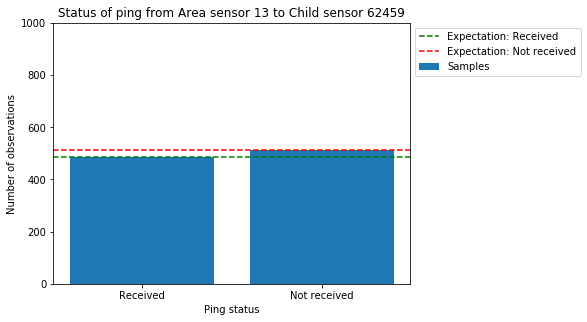

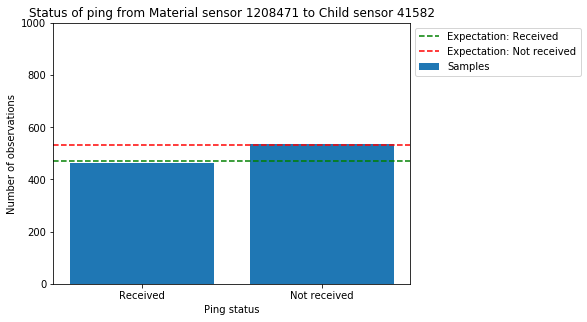

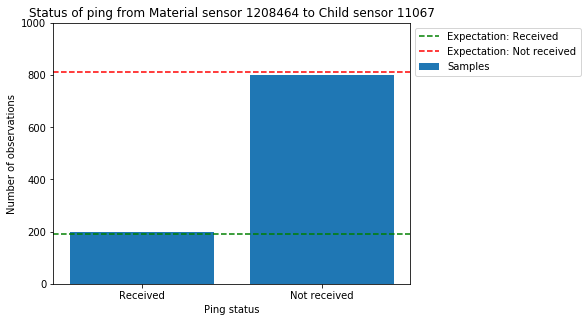

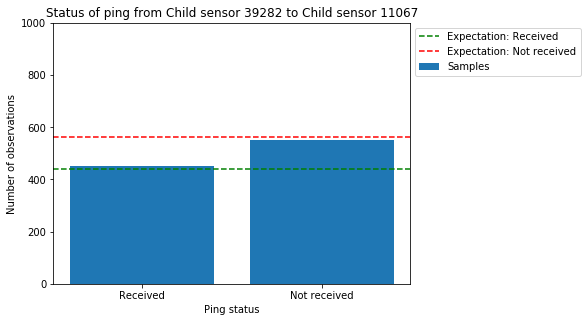

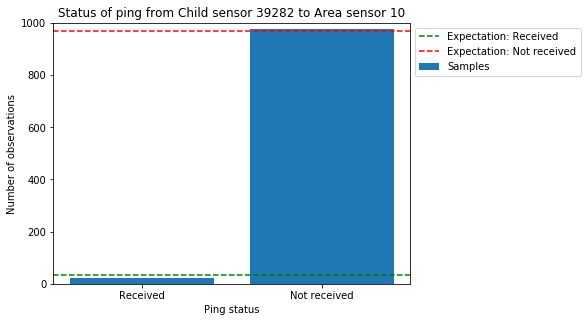

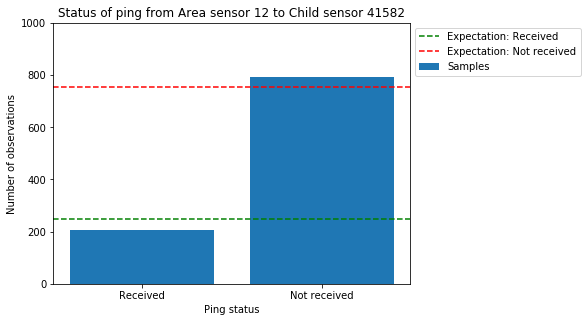

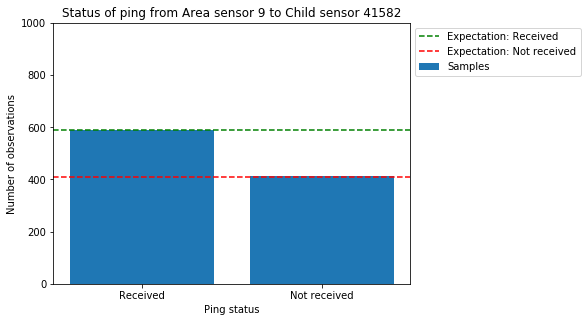

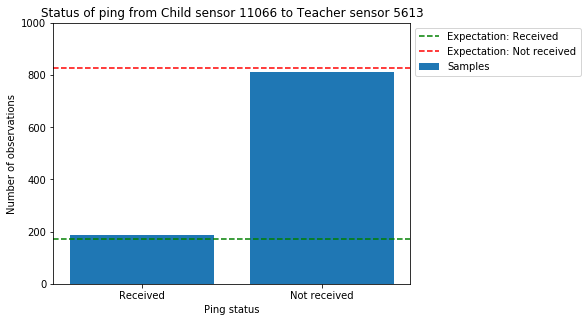

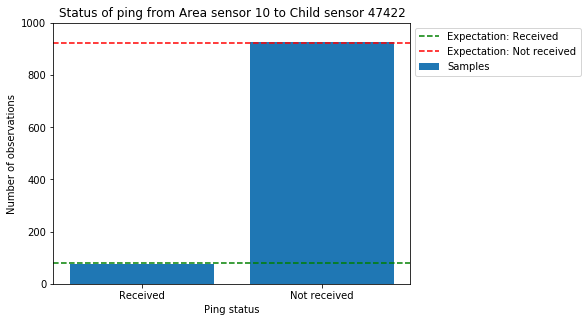

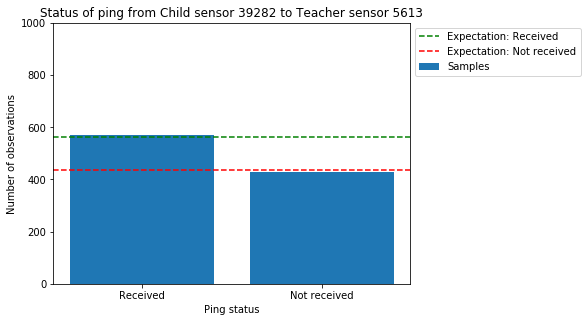

In [109]:
for y_discrete_var_index in np.random.choice(range(num_y_discrete_vars), size=10):
    plt.bar(range(num_ping_statuses), np.bincount(y_discrete_bar_x_samples[:,y_discrete_var_index]), label='Samples')
    for ping_status_index in range(num_ping_statuses):
        plt.axhline(y=ping_status_probabilities(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index]*1000,
                    linestyle='dashed',
                    color=['green', 'red'][ping_status_index],
                    label='Expectation: {}'.format(ping_status_names[ping_status_index]))
    plt.xticks(range(num_ping_statuses), ping_status_names)
    plt.xlabel('Ping status')
    plt.ylabel('Number of observations')
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.ylim(0, 1000)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For the sensor variables that measure the RSSI of the received pings, we model the measured RSSI as a Gaussian with a mean that drops off linearly in the log of the distance with a slope of -20 (i.e., $1/d^2$ fall-off), a large amount of noise, and a hard lower cut-off. First, we define functions that return the means of the truncated and untruncated distributions, given the distance between the sensors.

Find the minimum and maximum recorded RSSI values.

In [110]:
usable_data['rssi'].min()

-96

In [111]:
usable_data['rssi'].max()

-49

In [112]:
rssi_untruncated_mean_intercept = -69.18 # Mean RSSI at 1 meter (log(distance)=0); from analysis of rssi.random_walk.csv
rssi_untruncated_mean_slope = -20.0 # Creates a 1/r^2 fall-off
rssi_untruncated_std_dev = 5.70 # Noise value; from analysis of rssi.random_walk.csv
lower_rssi_cutoff = -96.0001 # Set just below lowest observed value above

In [113]:
def rssi_untruncated_mean(distance):
    return rssi_untruncated_mean_intercept + rssi_untruncated_mean_slope*np.log10(distance)

In [114]:
def rssi_truncated_mean(distance):
    return stats.truncnorm.stats(a=(lower_rssi_cutoff - rssi_untruncated_mean(distance))/rssi_untruncated_std_dev,
                                 b=np.inf,
                                 loc=rssi_untruncated_mean(distance),
                                 scale=rssi_untruncated_std_dev,
                                 moments='m')

Plot these functions to make sure they have the properties we expect.

In [115]:
rssi_range_min = rssi_untruncated_mean(distance_range_max)
rssi_range_max = rssi_untruncated_mean(distance_range_min)

c:\python27\lib\site-packages\scipy\stats\_continuous_distns.py:4870: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


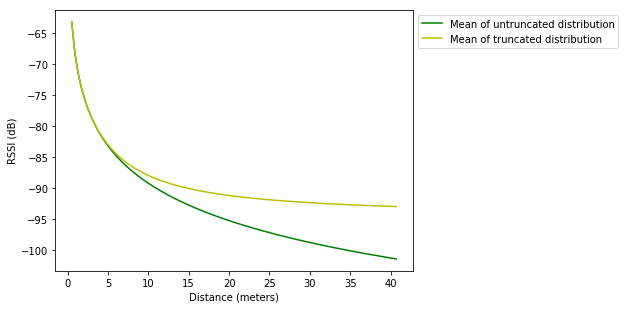

In [116]:
distance_range = np.linspace(distance_range_min, distance_range_max, 100)
plt.plot(distance_range,
         rssi_untruncated_mean(distance_range),
         'g-',
         label='Mean of untruncated distribution')
plt.plot(distance_range,
         rssi_truncated_mean(distance_range),
         'y-',
         label='Mean of truncated distribution')
plt.xlabel('Distance (meters)')
plt.ylabel('RSSI (dB)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a sanity check, note that the mean of the truncated distribution at 10 meters (roughly the median inter-sensor distance) is approximately -80 dB (roughly the median recorded RSSI value).

Using these functions, define a function a sample of an RSSI value, given the distance between two sensors.

In [117]:
def rssi_samples(distances):
    return stats.truncnorm.rvs(a=(lower_rssi_cutoff - rssi_untruncated_mean(distances))/rssi_untruncated_std_dev,
                               b=np.inf,
                               loc=rssi_untruncated_mean(distances),
                               scale=rssi_untruncated_std_dev)

Using this function, define a function that returns a sample of all of the RSSI readings, given all of the sensor positions.

In [118]:
def y_continuous_bar_x_sample(x_discrete, x_continuous):
    return rssi_samples(distances(sensor_positions(x_continuous)))

Generate 100,000 samples (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [119]:
time_start = time.clock()
y_continuous_bar_x_samples = y_continuous_bar_x_sample(np.tile(test_x_discrete_value, (100000, 1)),
                                                       np.tile(test_x_continuous_value, (100000, 1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 19.6577375213


Plot these samples for 10 randomly chosen continuous $\mathbf{Y}$ variables.

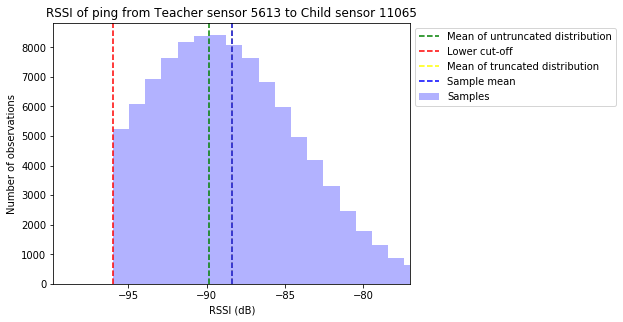

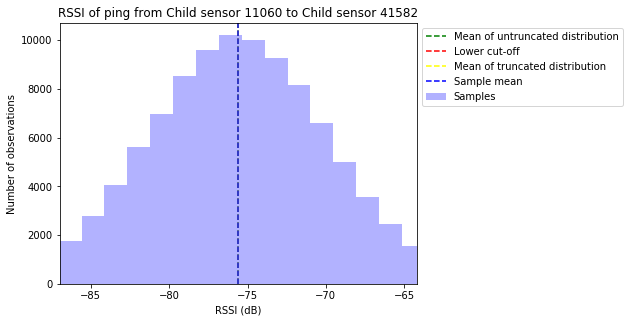

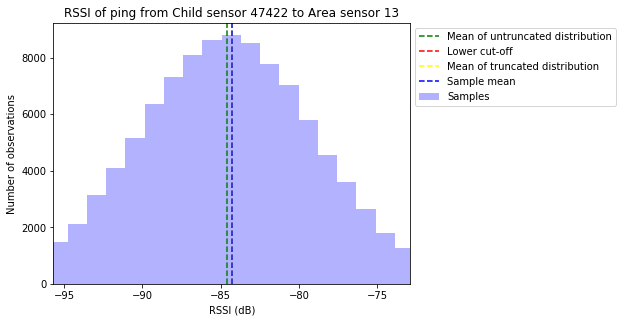

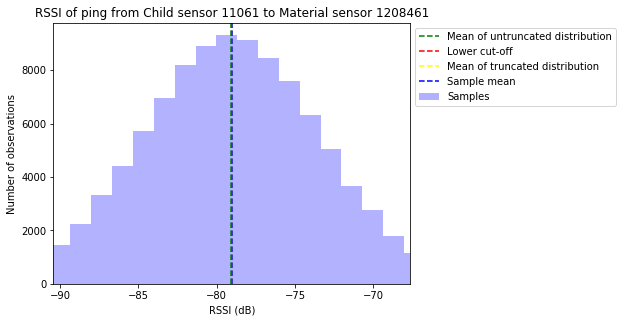

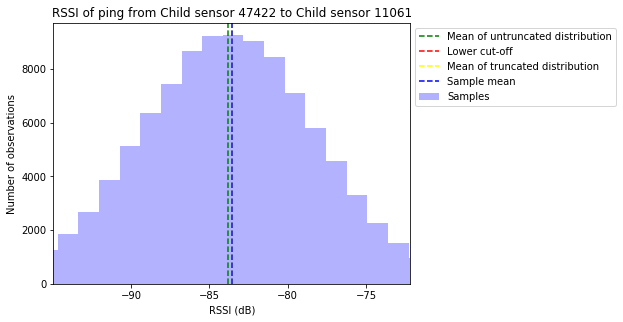

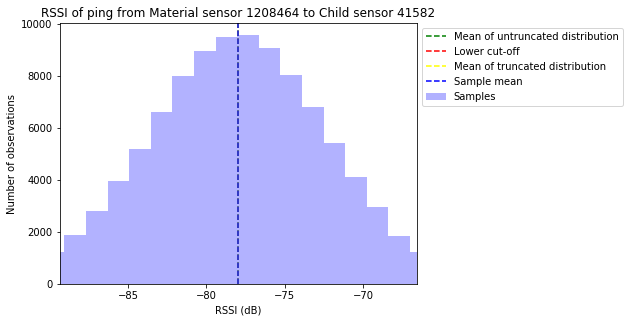

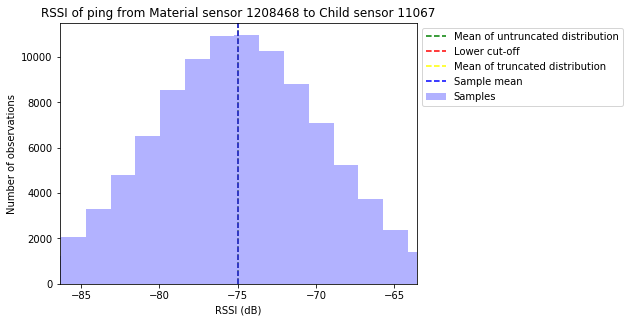

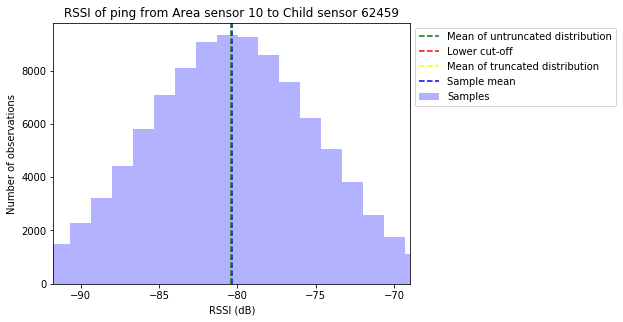

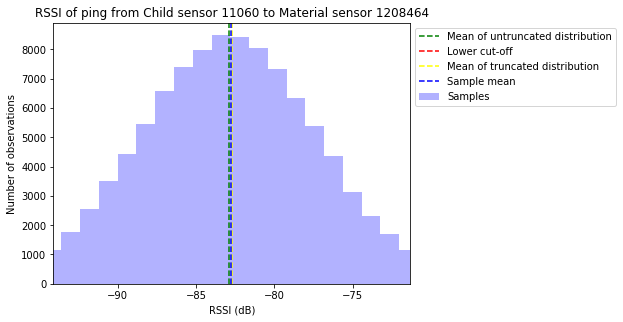

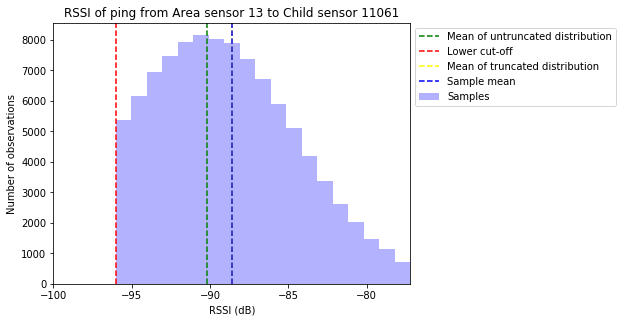

In [120]:
for y_continuous_var_index in np.random.choice(range(num_y_continuous_vars), size=10):
    plt.hist(y_continuous_bar_x_samples[:,y_continuous_var_index],
             bins=30,
             facecolor='blue',
             alpha=0.3,
             label='Samples')
    plt.axvline(x=rssi_untruncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='green',
                label='Mean of untruncated distribution')
    plt.axvline(lower_rssi_cutoff,
                linestyle='dashed',
                color='red',
                label='Lower cut-off')
    plt.axvline(x=rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='yellow',
                label='Mean of truncated distribution')
    plt.axvline(np.mean(y_continuous_bar_x_samples[:,y_continuous_var_index]),
                linestyle='dashed',
                color='blue',
                label='Sample mean')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Number of observations')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]) - 2*rssi_untruncated_std_dev,
             rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]) + 2*rssi_untruncated_std_dev)
    plt.show()

Combine the discrete and continuous sample functions to create the overall function for sampling $\mathbf{Y}_t$, given $\mathbf{X}_t$.

In [121]:
def y_bar_x_sample(x_discrete, x_continuous):
    return y_discrete_bar_x_sample(x_discrete, x_continuous), y_continuous_bar_x_sample(x_discrete, x_continuous)

#### Calculate probability density of $\mathbf{Y}$ given $\mathbf{X}$

Now we want to define the other form of our sensor response function, a function that gives us the probability density of $\mathbf{Y_t}$, given $\mathbf{X}_t$. First, we define a function that returns the log of the probability density for a left truncated normal distribution (we define our own function because the corresponding `scipy` function has a bug in it).

In [122]:
def left_truncnorm_logpdf(x, untruncated_mean, untruncated_std_dev, left_cutoff):
    logf = np.array(np.subtract(stats.norm.logpdf(x, loc=untruncated_mean, scale=untruncated_std_dev),
                                np.log(1 - stats.norm.cdf(left_cutoff, loc=untruncated_mean, scale=untruncated_std_dev))))
    logf[x < left_cutoff] = -np.inf
    return logf

Using this function (and the various functions and variable defined above), define a function that returns the log of the probabilty density for a given value of all of the sensors variables (ping statuses and received RSSIs), given the values of all of the state variables (the positions of all of the sensors).

In [123]:
def log_f_y_bar_x(x_discrete, x_continuous, y_discrete, y_continuous):
    distances_x = distances(sensor_positions(x_continuous))
    ping_status_probabilities_x = ping_status_probabilities(distances_x)
    discrete_log_probabilities = np.log(np.choose(y_discrete,
                                                  np.rollaxis(ping_status_probabilities_x, axis=-1)))
    continuous_log_probability_densities = left_truncnorm_logpdf(y_continuous,
                                                                 rssi_untruncated_mean(distances_x),
                                                                 rssi_untruncated_std_dev,
                                                                 lower_rssi_cutoff)
    continuous_log_probability_densities[y_discrete == 1] = 0.0
    return np.sum(discrete_log_probabilities, axis=-1) + np.sum(continuous_log_probability_densities, axis=-1)

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. First we plot the dependence on the discrete sensor variables for 10 randomly chosen variables.

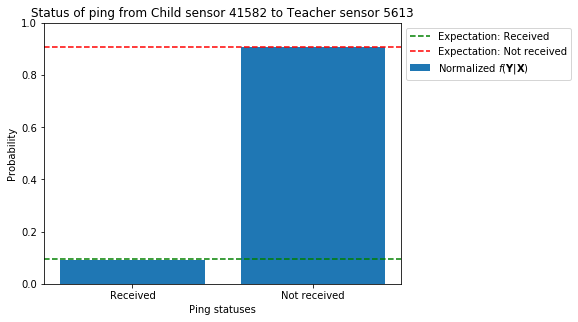

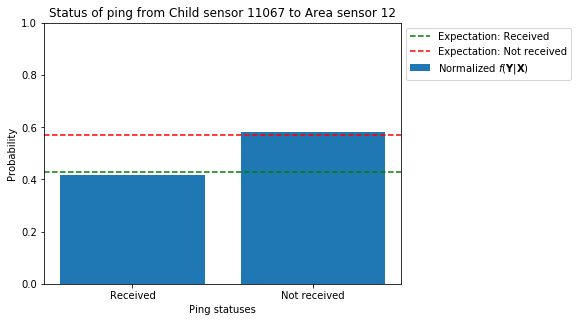

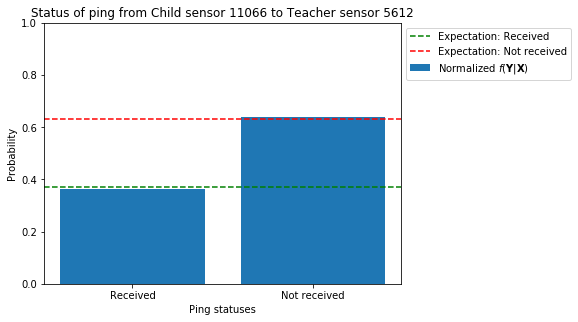

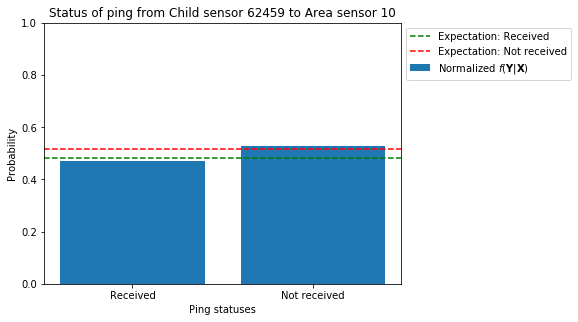

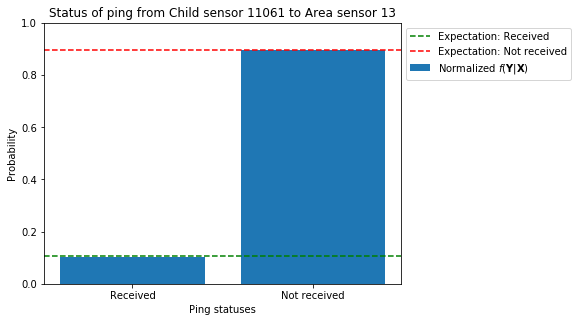

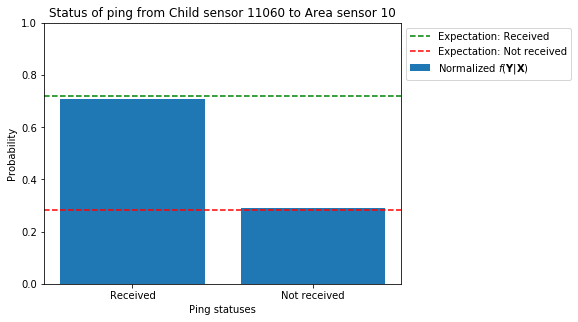

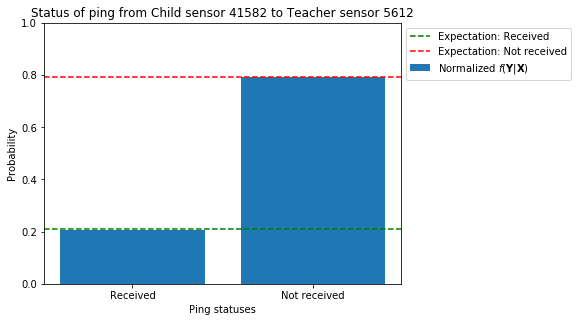

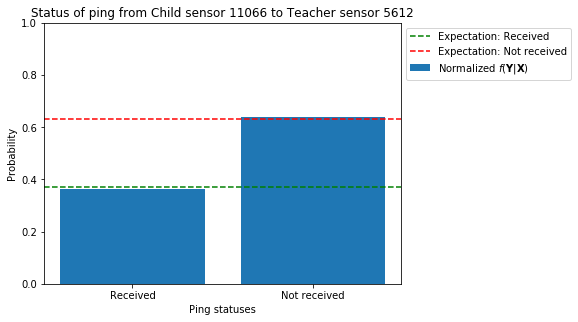

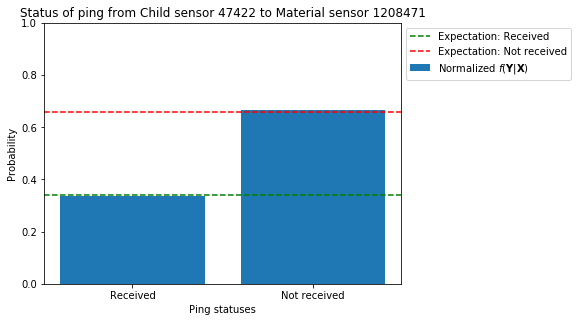

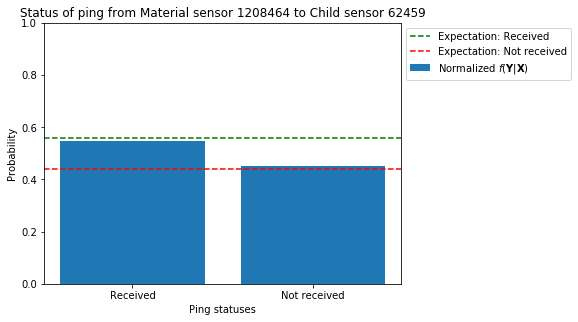

In [124]:
mean_rssi_values = rssi_truncated_mean(distances_test_x_continuous_value)
for y_discrete_var_index in np.random.choice(range(num_y_discrete_vars), size=10):
    test_y_discrete_value = np.repeat(0, num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    log_probability_range = np.zeros(2, dtype='float')
    log_probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(mean_rssi_values[y_discrete_var_index] - 2*rssi_untruncated_std_dev,
                           mean_rssi_values[y_discrete_var_index] + 2*rssi_untruncated_std_dev,
                           100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_discrete_var_index] = rssi_range[rssi_index]
        log_probability_density_range[rssi_index] = log_f_y_bar_x(test_x_discrete_value,
                                                                  test_x_continuous_value,
                                                                  test_y_discrete_value,
                                                                  test_y_continuous_value)
    log_probability_range[0] = misc.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0])
    test_y_discrete_value[y_discrete_var_index] = 1
    test_y_continuous_value = mean_rssi_values
    log_probability_range[1] = log_f_y_bar_x(test_x_discrete_value,
                                             test_x_continuous_value,
                                             test_y_discrete_value,
                                             test_y_continuous_value)
    log_probability_range = log_probability_range - misc.logsumexp(log_probability_range)
    plt.bar(range(num_ping_statuses),
            np.exp(log_probability_range),
            label='Normalized $f(\mathbf{Y}|\mathbf{X})$')
    for ping_status_index in range(num_ping_statuses):
        plt.axhline(y=ping_status_probabilities(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index],
                    linestyle='dashed',
                    color=['green', 'red'][ping_status_index],
                    label='Expectation: {}'.format(ping_status_names[ping_status_index]))
    plt.xticks(range(num_ping_statuses), ping_status_names)
    plt.ylim(0,1)
    plt.xlabel('Ping statuses')
    plt.ylabel('Probability')
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Now we plot the dependence on the continuous sensor variables for 10 randomly chosen variables.

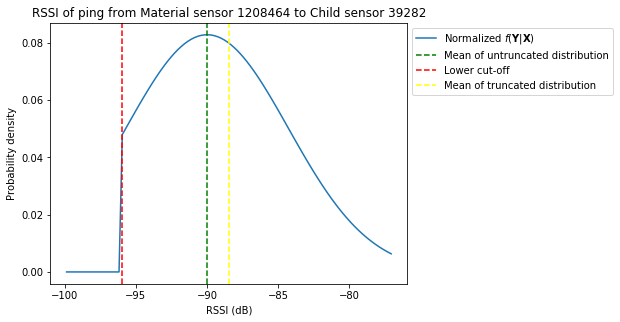

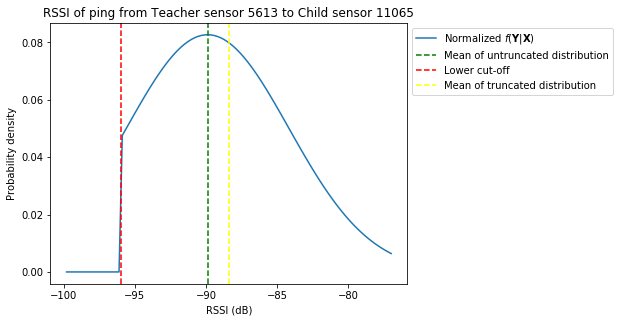

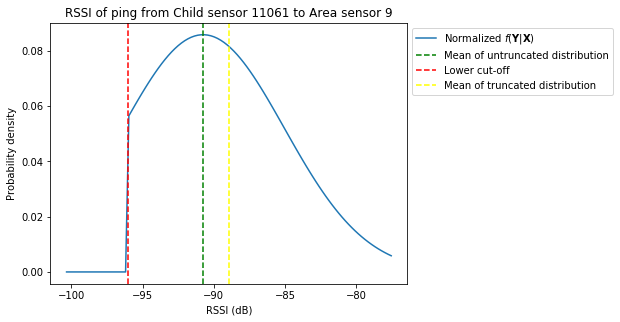

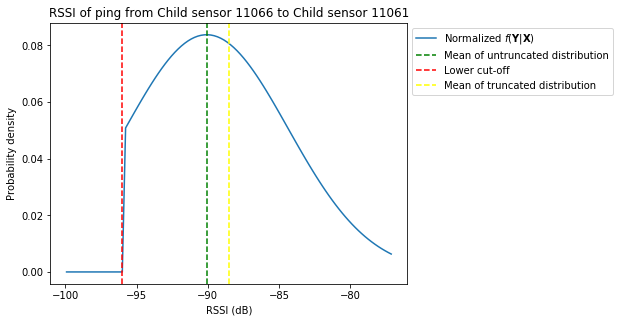

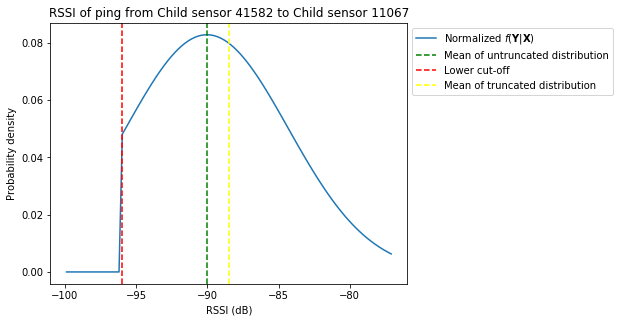

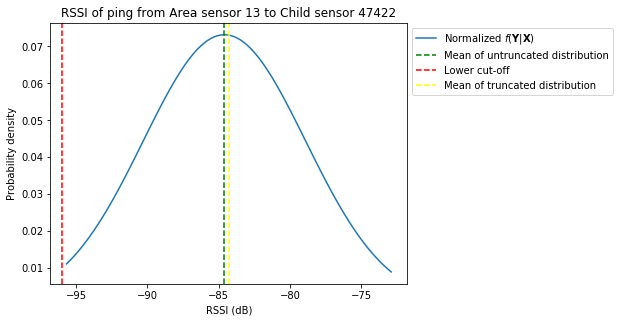

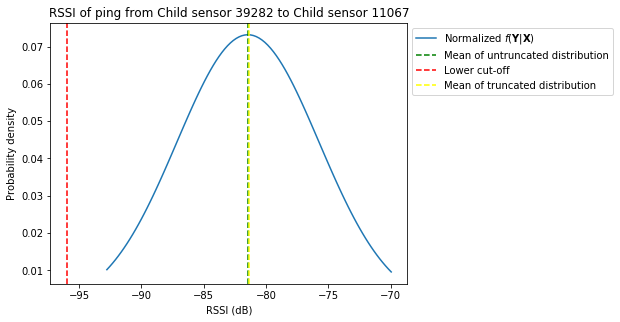

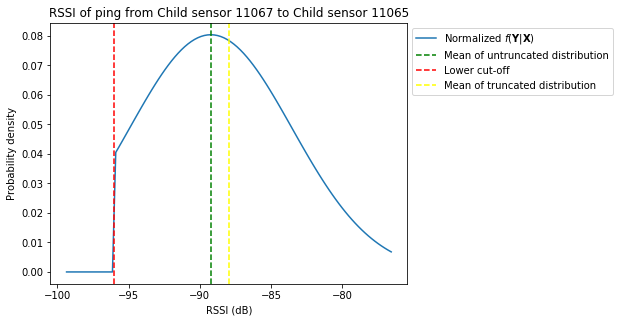

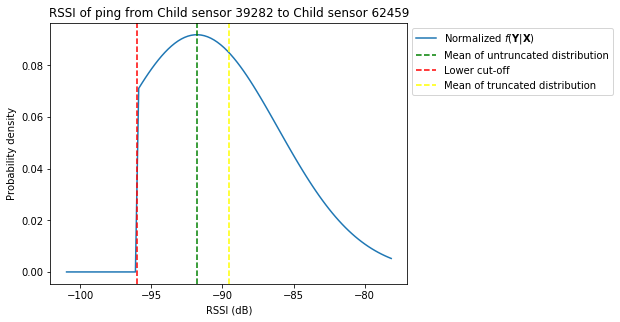

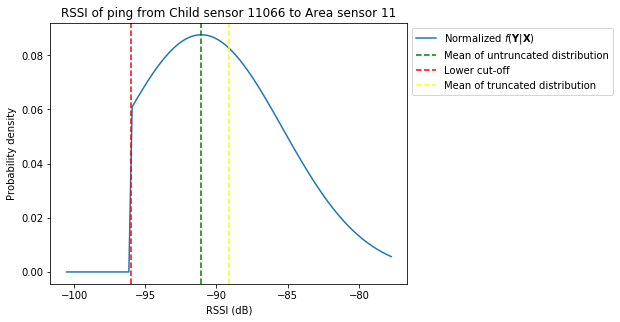

In [125]:
mean_rssi_values = rssi_truncated_mean(distances_test_x_continuous_value)
for y_continuous_var_index in np.random.choice(range(num_y_continuous_vars), size=10):
    test_y_discrete_value = np.repeat(0, num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    log_probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(mean_rssi_values[y_continuous_var_index] - 2*rssi_untruncated_std_dev,
                           mean_rssi_values[y_continuous_var_index] + 2*rssi_untruncated_std_dev,
                           100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_continuous_var_index] = rssi_range[rssi_index]
        log_probability_density_range[rssi_index] = log_f_y_bar_x(test_x_discrete_value,
                                                                  test_x_continuous_value,
                                                                  test_y_discrete_value,
                                                                  test_y_continuous_value)
    log_probability_density_range = log_probability_density_range - (misc.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0]))
    plt.plot(rssi_range, np.exp(log_probability_density_range), label='Normalized $f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(x=rssi_untruncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='green',
                label='Mean of untruncated distribution')
    plt.axvline(lower_rssi_cutoff,
                linestyle='dashed',
                color='red',
                label='Lower cut-off')
    plt.axvline(x=rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='yellow',
                label='Mean of truncated distribution')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Probability density')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the real data using a particle filter

Set the number of particles and initialize variables.

In [126]:
num_particles = 10000
particle_discrete_values = np.zeros((num_timesteps, num_particles, num_x_discrete_vars), dtype = 'int')
particle_continuous_values = np.zeros((num_timesteps, num_particles, num_x_continuous_vars), dtype = 'float')
log_particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')
sampled_particle_indices = np.zeros((num_timesteps, num_particles), dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [127]:
time_start = time.clock()
particle_discrete_values[0], particle_continuous_values[0] = x_initial_sample(num_particles)
log_particle_weights[0] = log_f_y_bar_x(particle_discrete_values[0],
                                        particle_continuous_values[0],
                                        np.tile(y_discrete_t[0], (num_particles,1)),
                                        np.tile(y_continuous_t[0], (num_particles,1)))
log_particle_weights[0] = log_particle_weights[0] - misc.logsumexp(log_particle_weights[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 2.05807535622


Calculate the particles for all times $t>0$.

In [128]:
sys.stdout.write('t_index =')
sys.stdout.flush()
time_start = time.clock()
for t_index in range(1, num_timesteps):
    sys.stdout.write(' {}'.format(t_index))
    sys.stdout.flush()
    sampled_particle_indices[t_index - 1] = np.random.choice(num_particles,
                                                             size=num_particles,
                                                             p=np.exp(log_particle_weights[t_index - 1]))
    particle_discrete_values[t_index], particle_continuous_values[t_index] = x_bar_x_prev_sample(particle_discrete_values[t_index - 1,
                                                                                                                          sampled_particle_indices[t_index - 1]],
                                                                                                 particle_continuous_values[t_index - 1,
                                                                                                                            sampled_particle_indices[t_index - 1]])
    log_particle_weights[t_index] = log_f_y_bar_x(particle_discrete_values[t_index],
                                                  particle_continuous_values[t_index],
                                                  np.tile(y_discrete_t[t_index], (num_particles,1)),
                                                  np.tile(y_continuous_t[t_index], (num_particles,1)))
    log_particle_weights[t_index] = log_particle_weights[t_index]- misc.logsumexp(log_particle_weights[t_index])
print'\nTime elapsed = {}'.format(time.clock()-time_start)

t_index = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 27

Calculate and plot the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [129]:
max_weights = np.max(np.exp(log_particle_weights), axis=1)

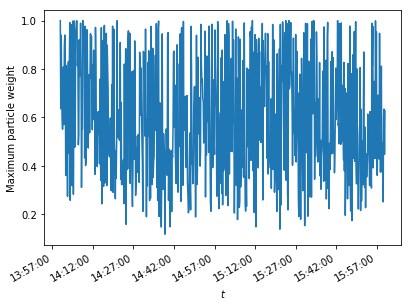

In [130]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t, max_weights)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Calculate and plot the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [131]:
num_sampled_particles = np.array([len(np.unique(sampled_particle_indices[t_index])) for t_index in range(num_timesteps)])

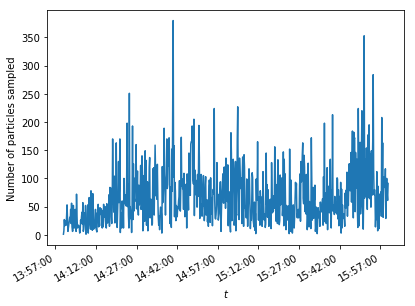

In [132]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t[:-1], num_sampled_particles[:-1])
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Calculate the sample means and sample standard deviations of continuous $\mathbf{X}$ variables for the particles at each time $t$.

In [133]:
x_continuous_mean_particle = np.average(
    particle_continuous_values, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), num_x_continuous_vars).reshape((num_timesteps, num_particles, num_x_continuous_vars))
)

In [134]:
x_continuous_squared_mean_particle = np.average(
    np.square(particle_continuous_values), 
    axis=1,
    weights=np.repeat(np.exp(log_particle_weights), num_x_continuous_vars).reshape((num_timesteps, num_particles, num_x_continuous_vars))
)

In [135]:
x_continuous_sd_particle = np.sqrt(np.abs(x_continuous_squared_mean_particle - np.square(x_continuous_mean_particle)))

Plot the sample means of the particles.

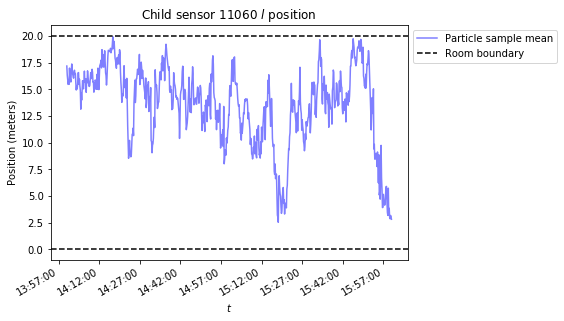

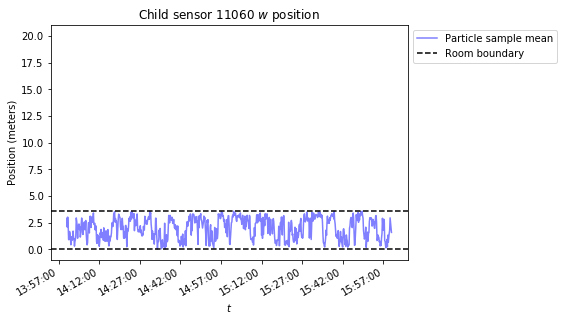

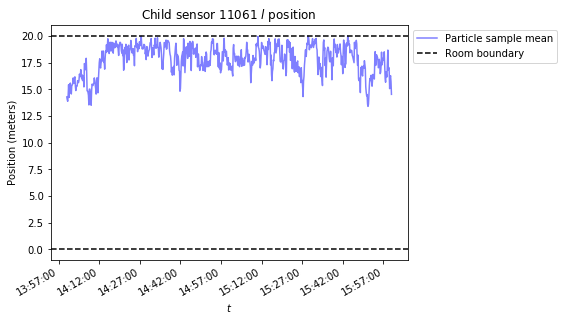

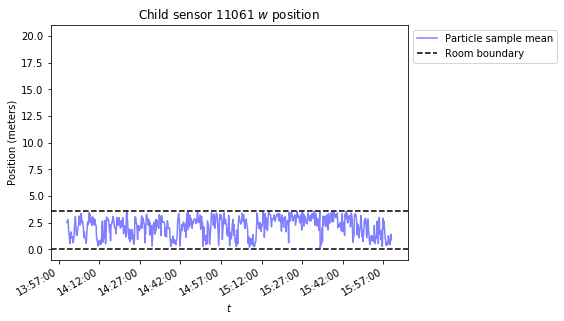

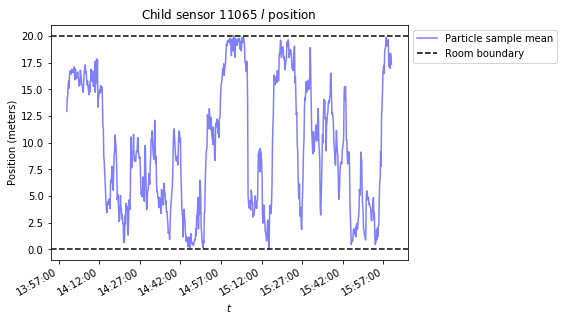

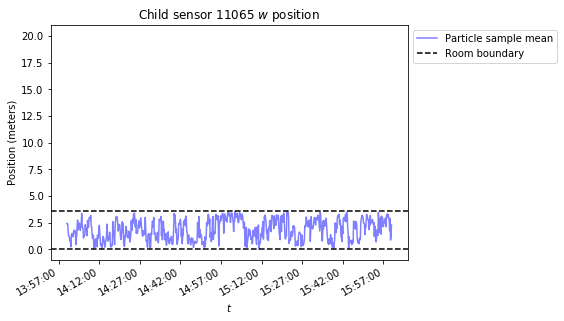

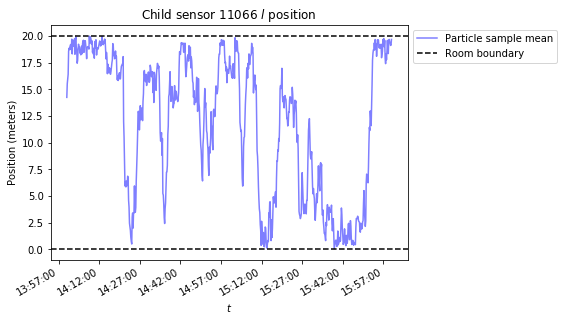

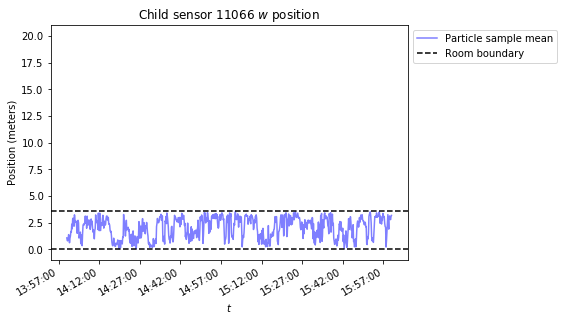

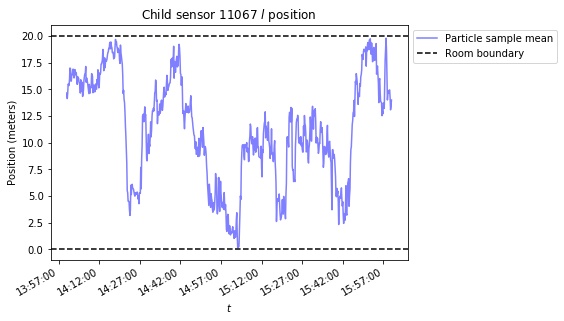

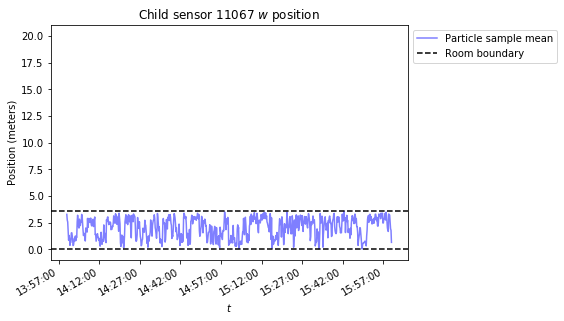

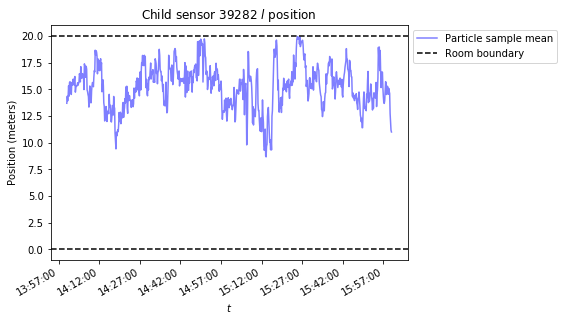

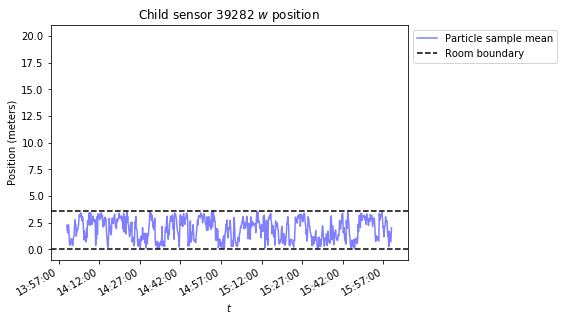

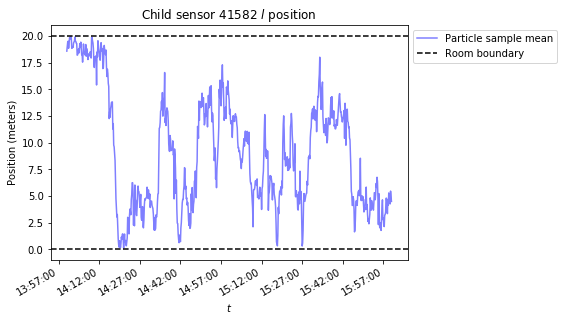

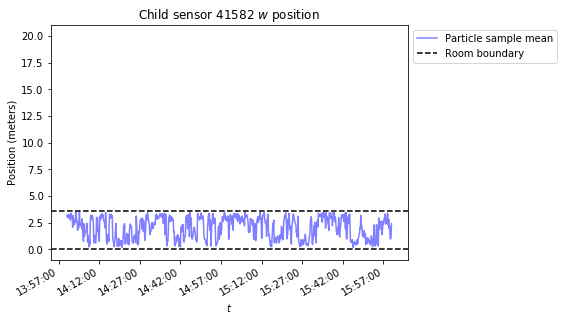

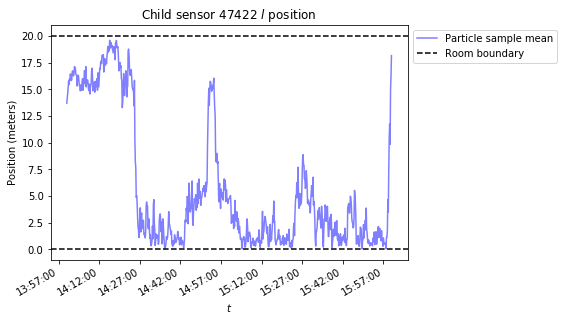

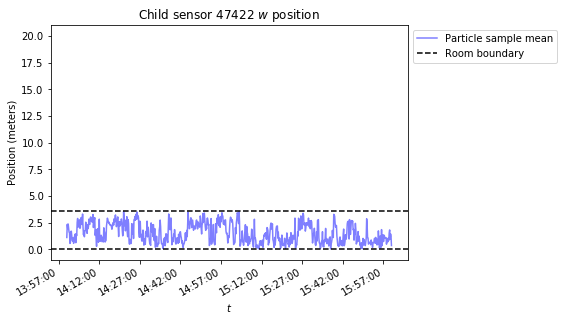

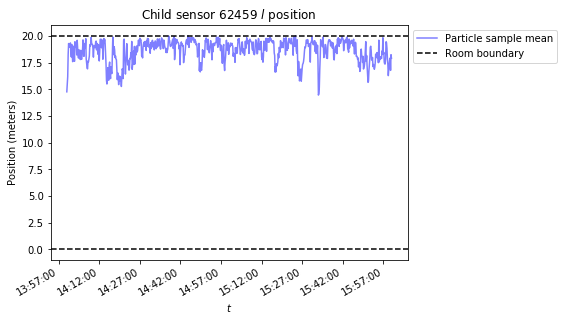

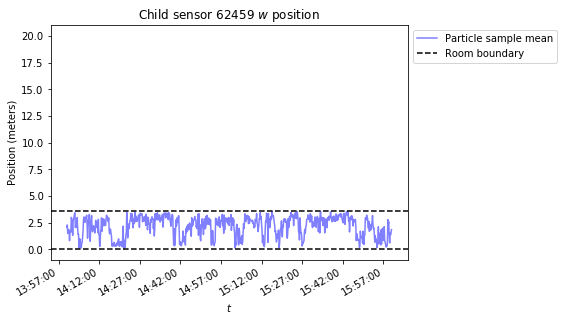

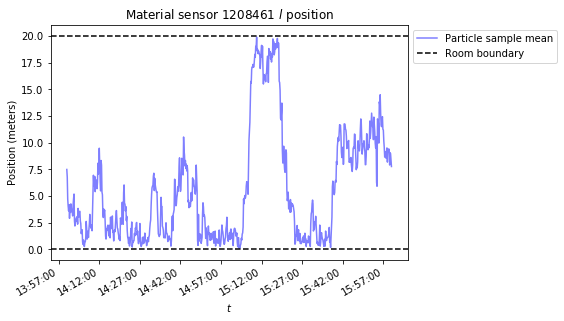

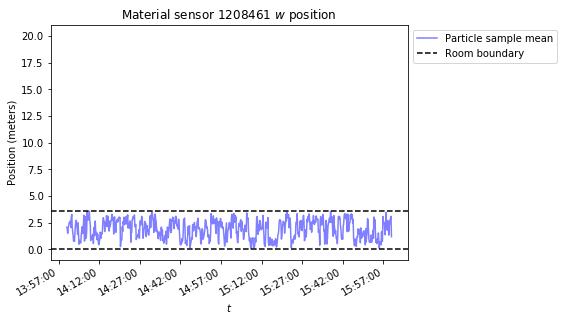

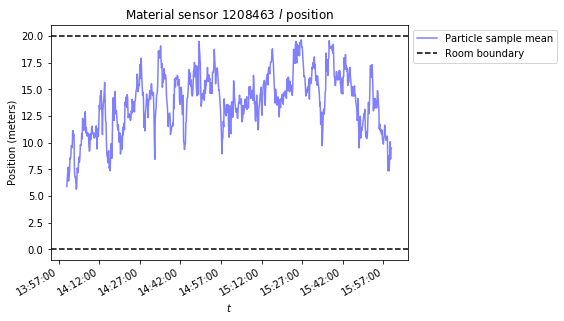

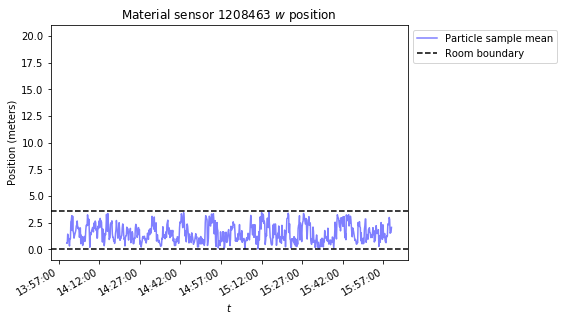

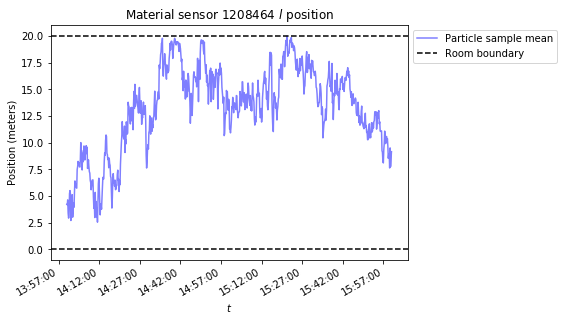

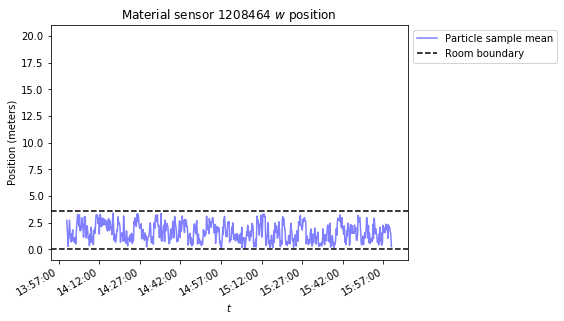

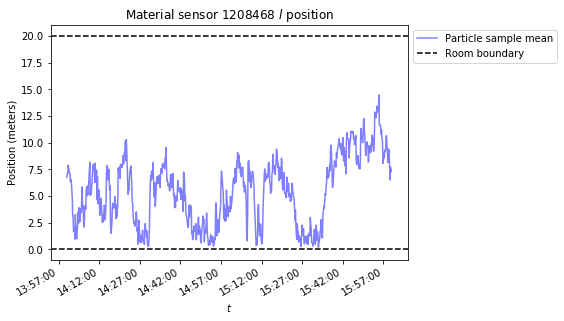

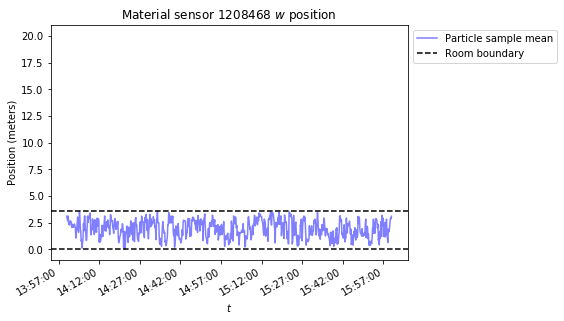

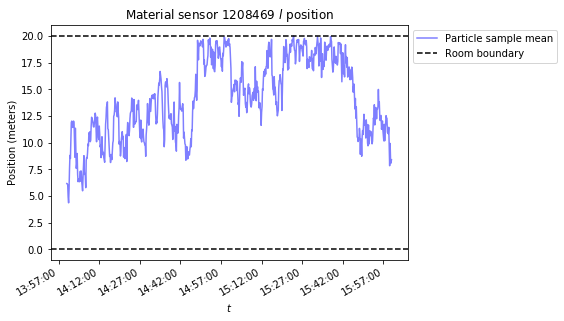

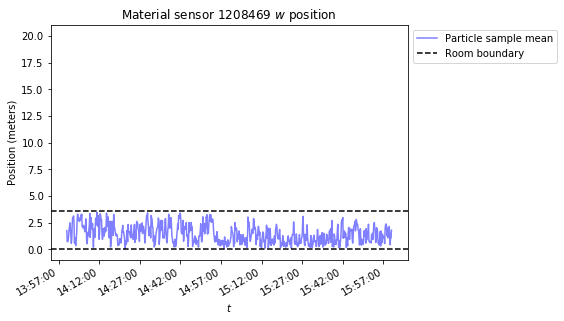

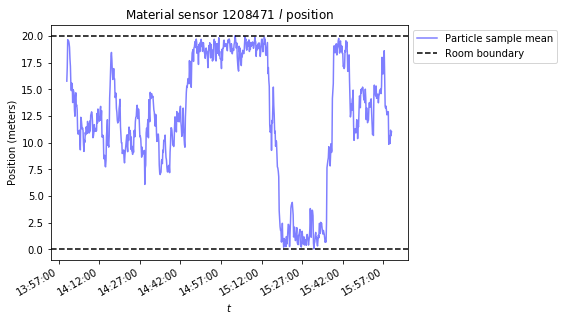

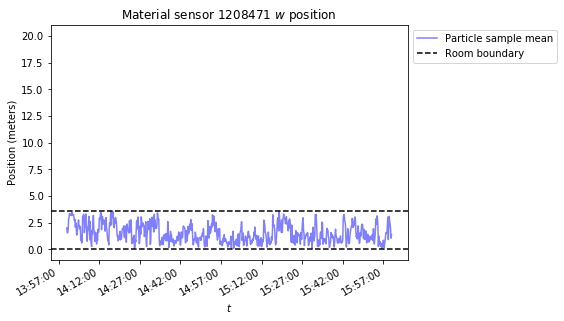

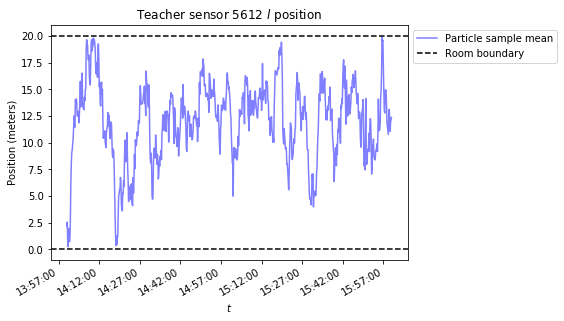

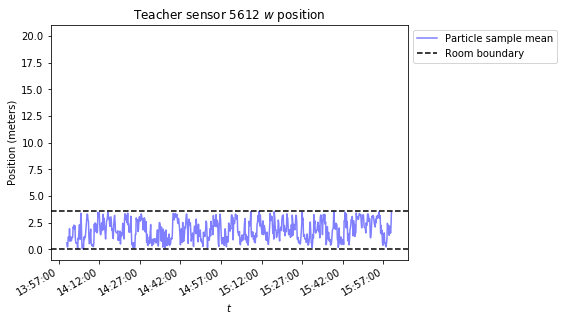

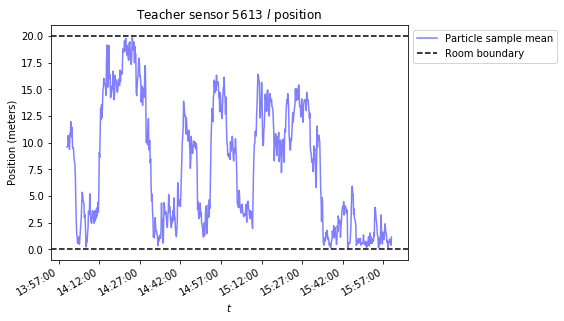

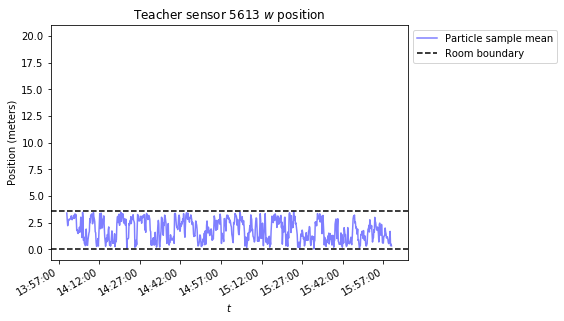

In [136]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(num_x_continuous_vars):
    plt.plot(t, x_continuous_mean_particle[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

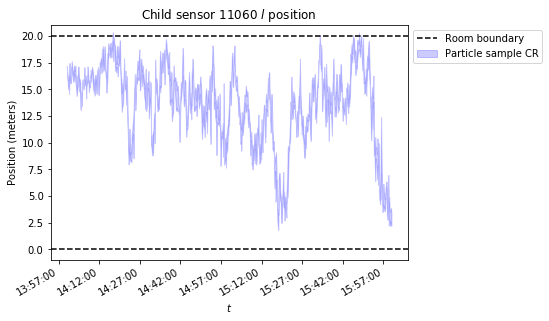

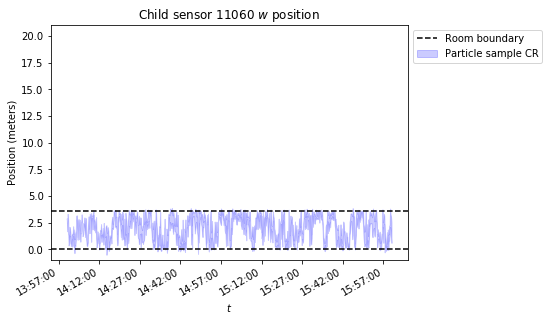

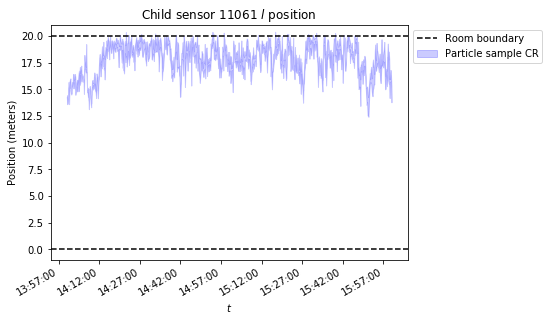

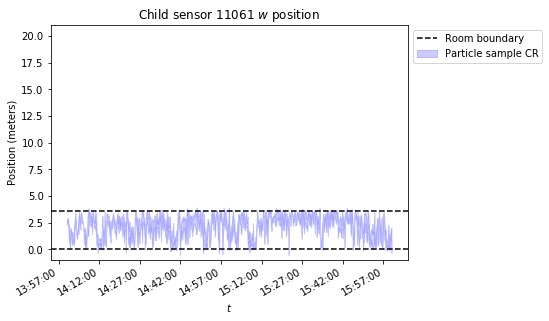

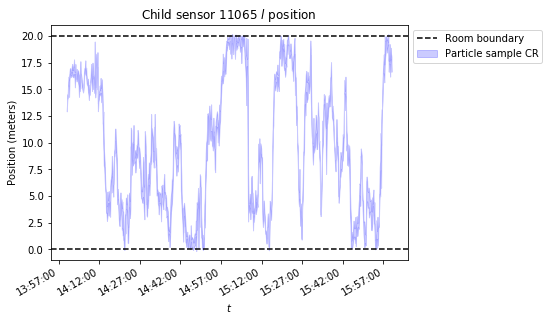

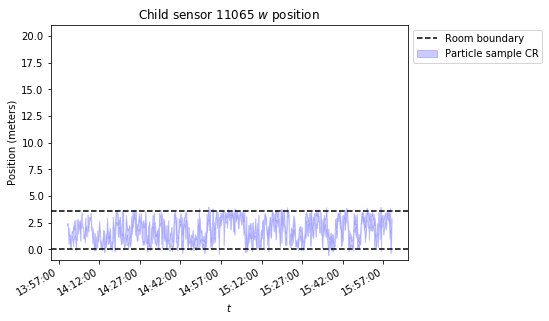

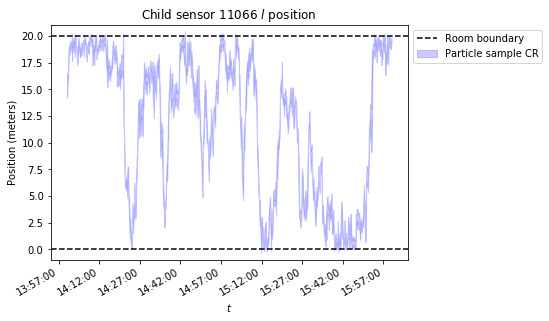

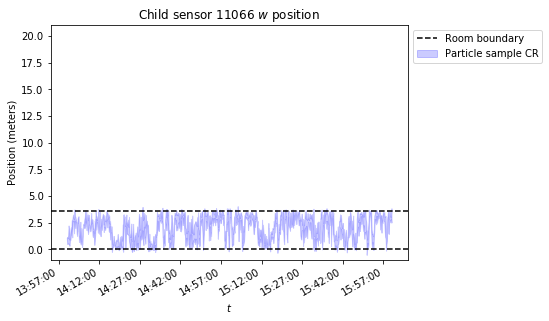

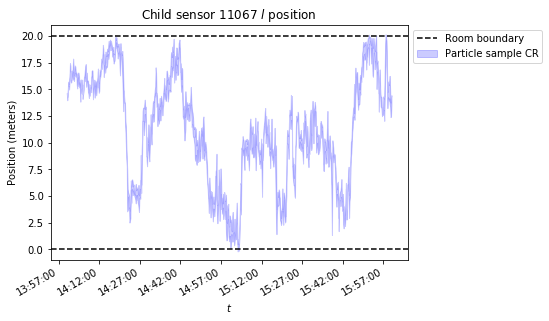

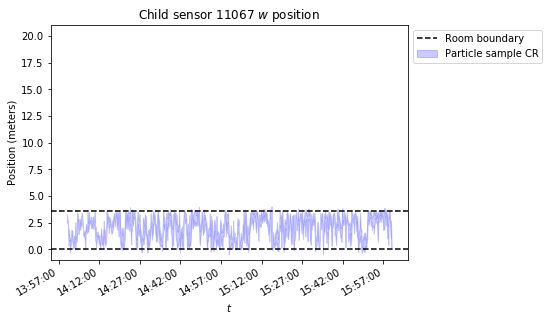

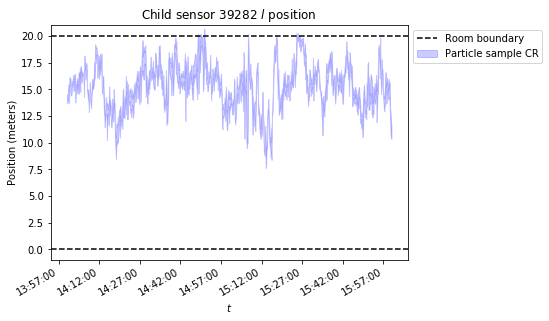

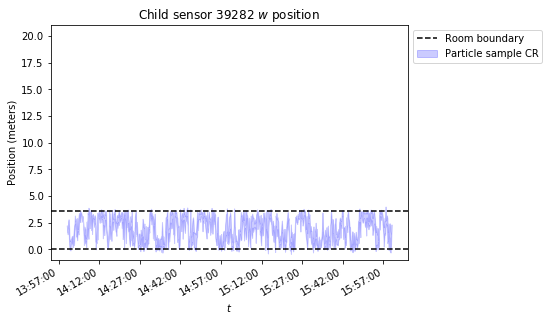

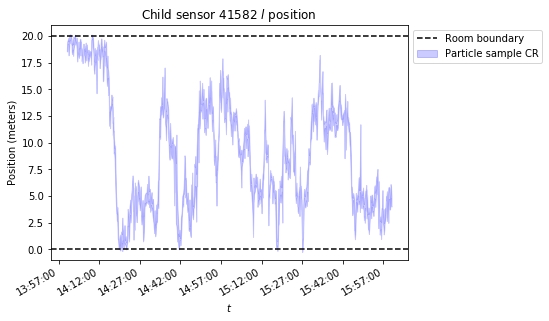

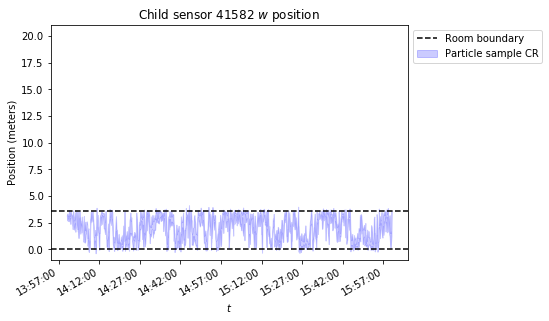

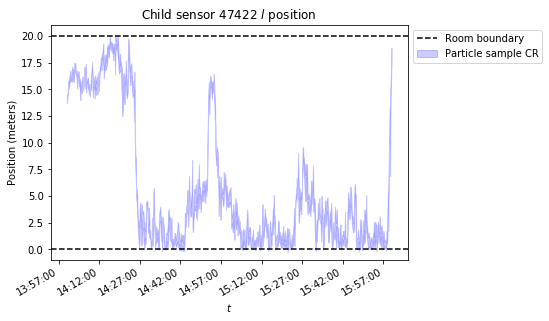

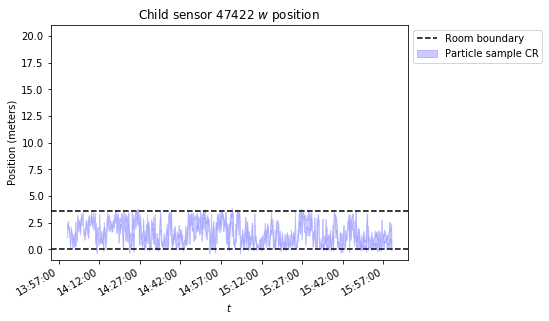

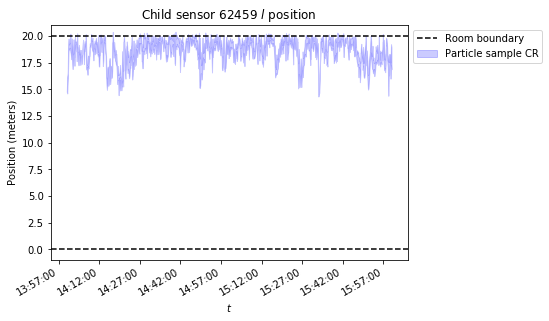

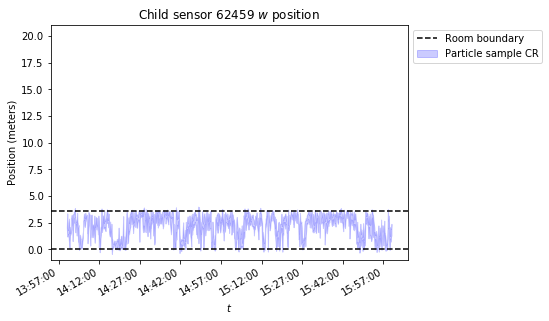

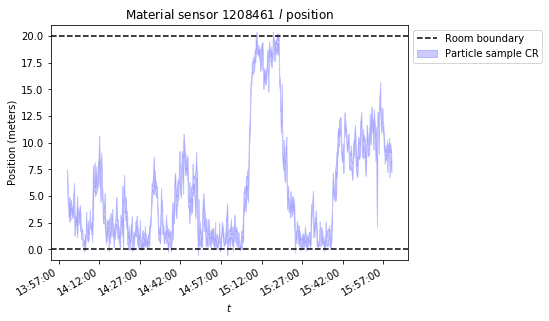

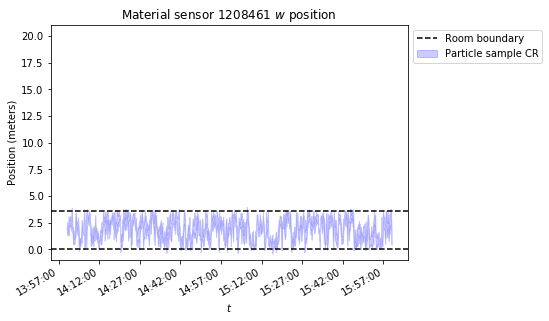

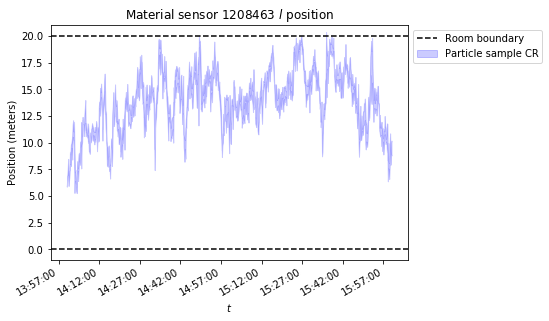

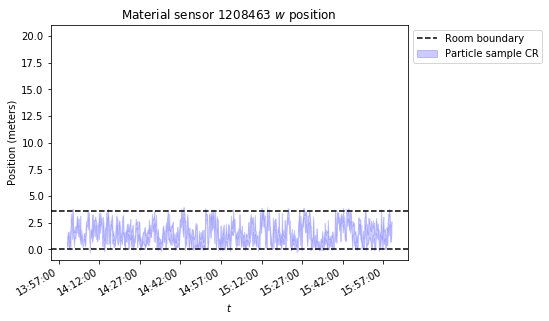

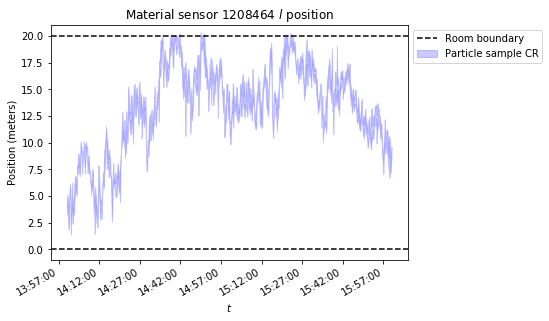

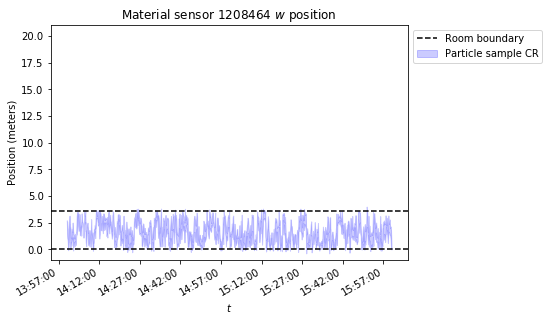

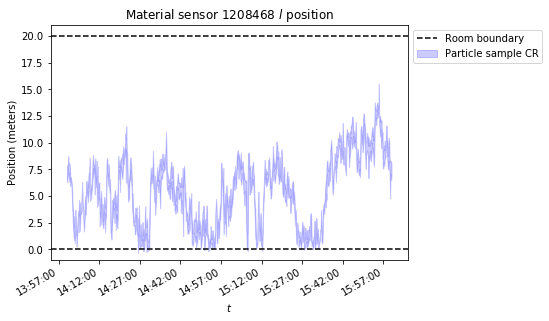

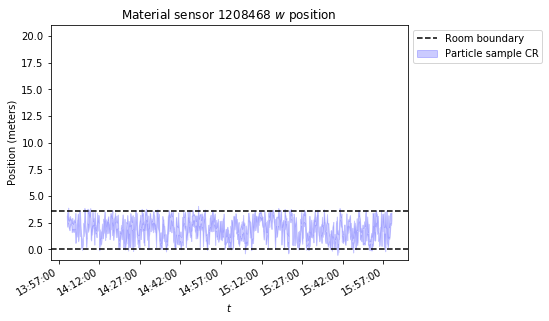

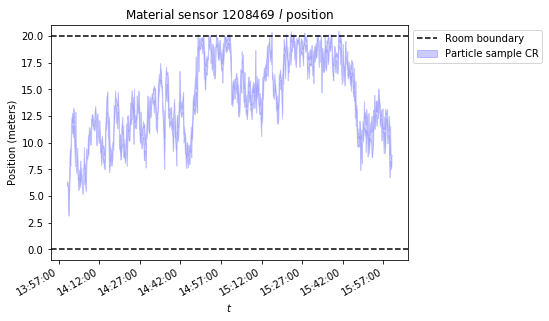

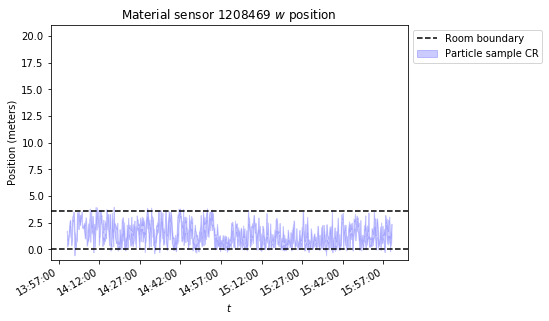

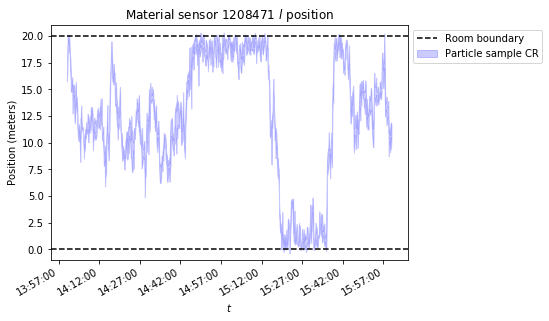

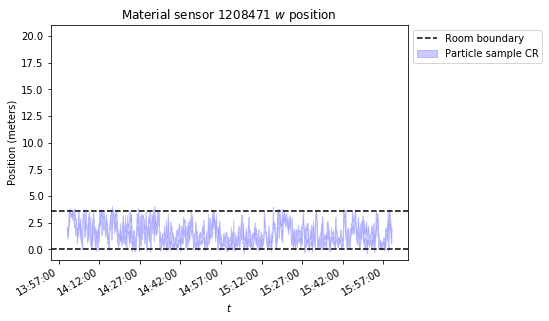

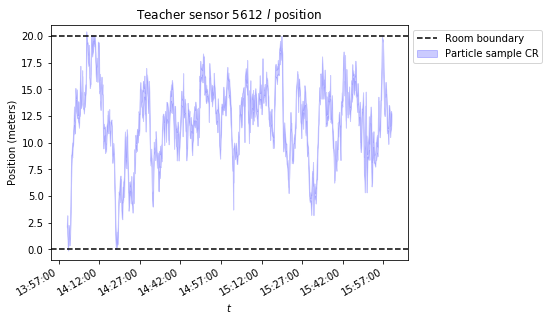

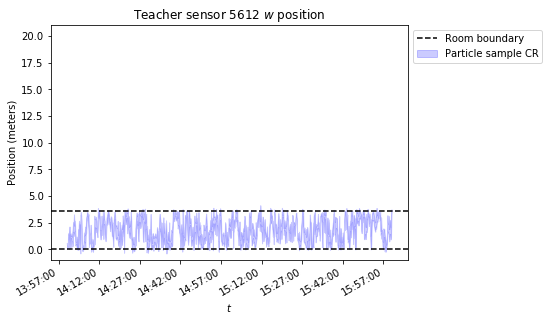

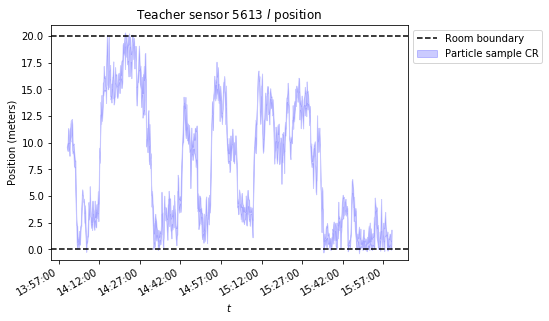

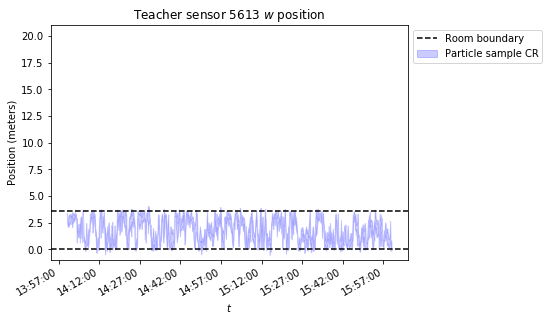

In [137]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(num_x_continuous_vars):
    plt.fill_between(
        t,
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Now we want to run the same calculation, but with simulated sensor data. This allows us to see how accurately the model can infer positions when the conditional probability distributions of the actual data match the assumptions in the model exactly.

Set the number of timesteps and initialize the variables.

In [138]:
num_timesteps = 100
t = np.zeros(num_timesteps, dtype='float')
x_discrete_t = np.zeros((num_timesteps, num_x_discrete_vars), dtype='int')
x_continuous_t = np.zeros((num_timesteps, num_x_continuous_vars), dtype='float')
y_discrete_t = np.zeros((num_timesteps, num_y_discrete_vars), dtype='int')
y_continuous_t = np.zeros((num_timesteps, num_y_continuous_vars), dtype='float')

Calculate the simulated data for $t=0$.

In [139]:
t[0] = 0.0

In [140]:
x_discrete_t[0], x_continuous_t[0] = x_initial_sample()

In [141]:
y_discrete_t[0], y_continuous_t[0] = y_bar_x_sample(x_discrete_t[0], x_continuous_t[0])

Calculate the simulated data for $t>0$.

In [142]:
timestep_size = 10.0

In [143]:
for t_index in range(1,num_timesteps):
    t[t_index] = t[t_index - 1] + timestep_size
    x_discrete_t[t_index], x_continuous_t[t_index] = x_bar_x_prev_sample(x_discrete_t[t_index - 1],
                                                                         x_continuous_t[t_index - 1])
    y_discrete_t[t_index], y_continuous_t[t_index] = y_bar_x_sample(x_discrete_t[t_index],
                                                                    x_continuous_t[t_index])

Plot the positions of the sensors to make sure they have the properties we expect.

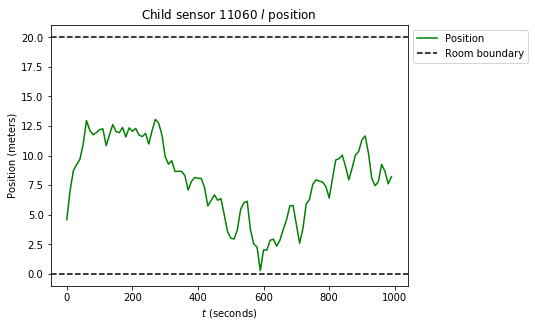

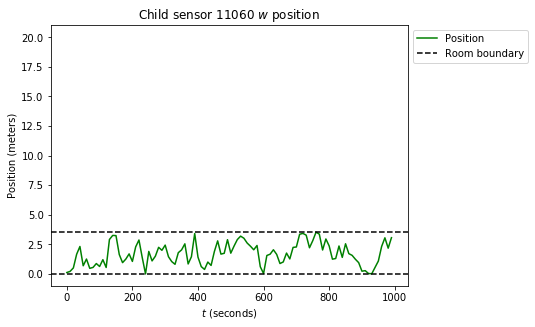

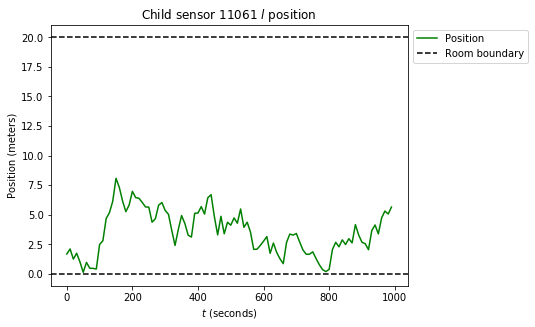

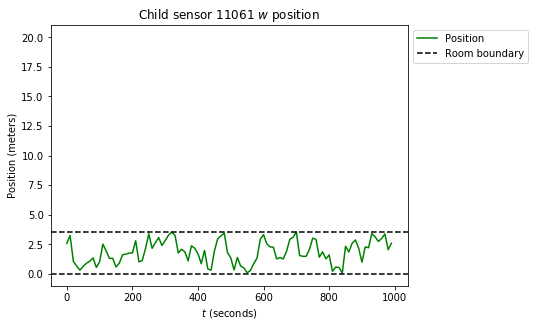

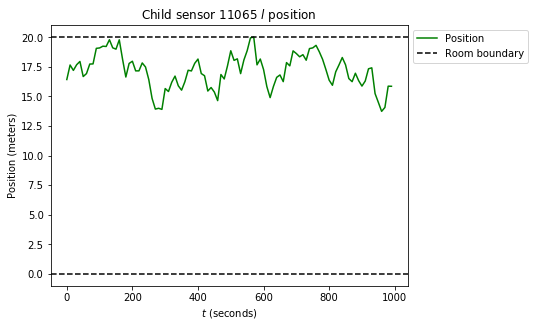

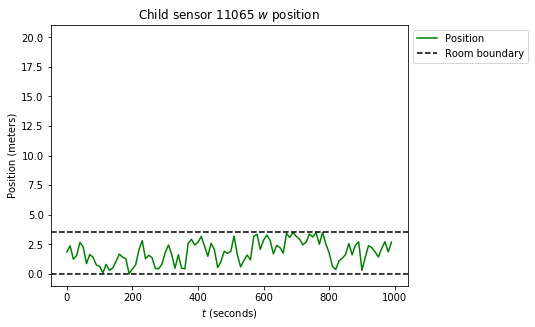

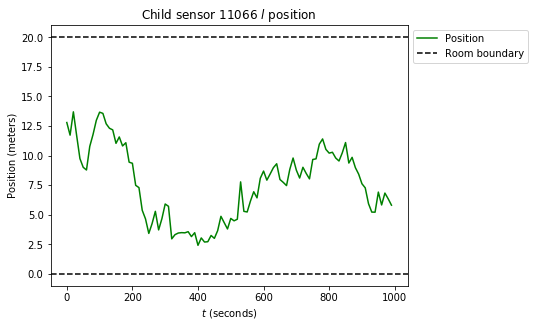

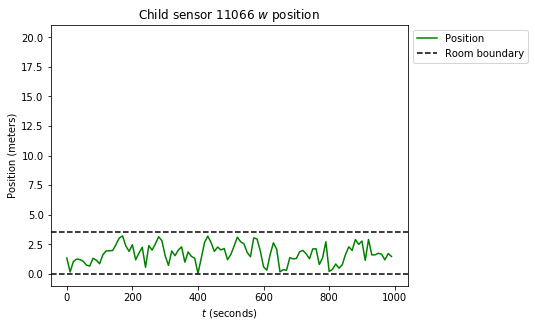

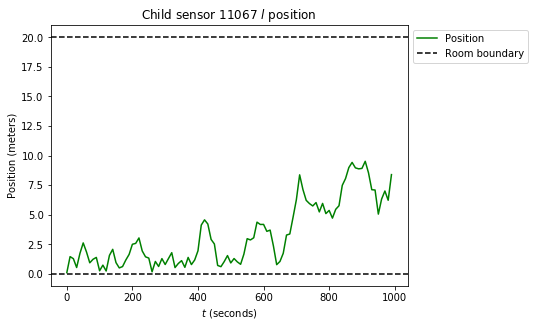

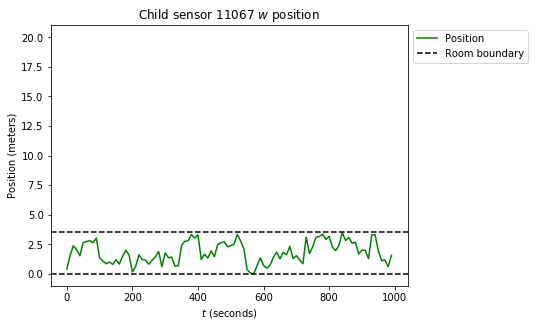

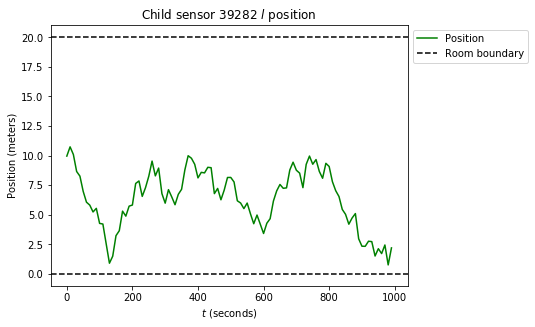

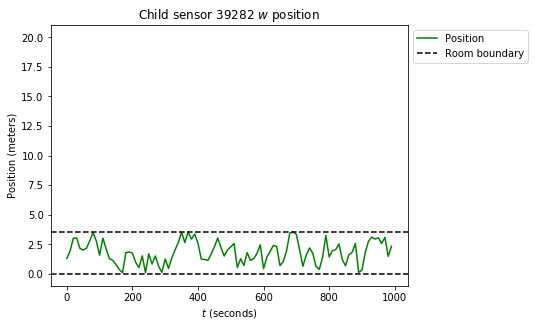

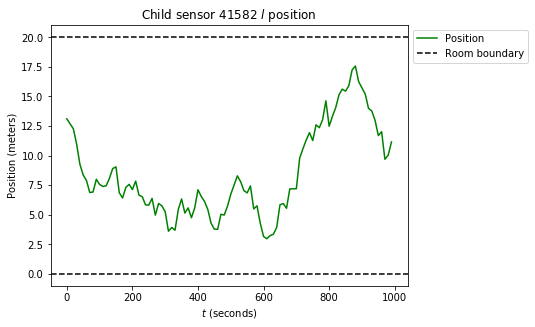

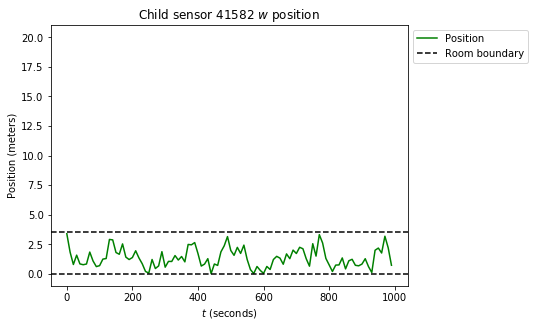

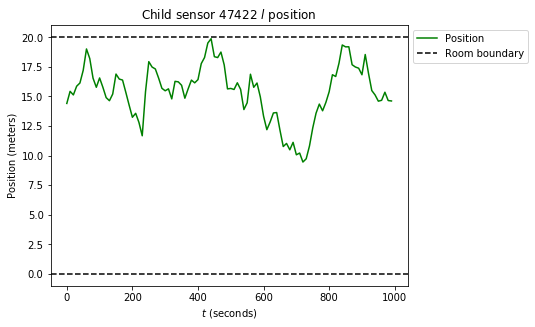

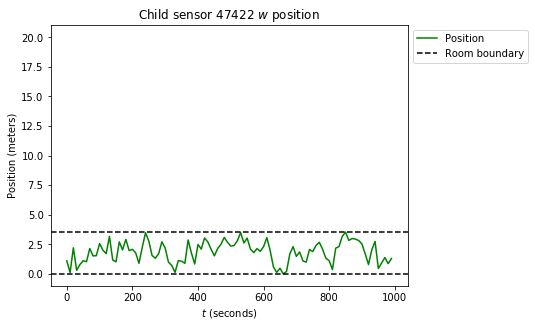

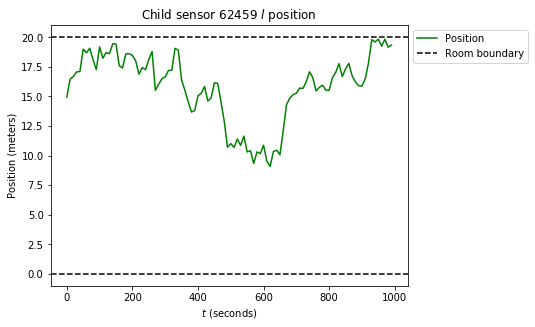

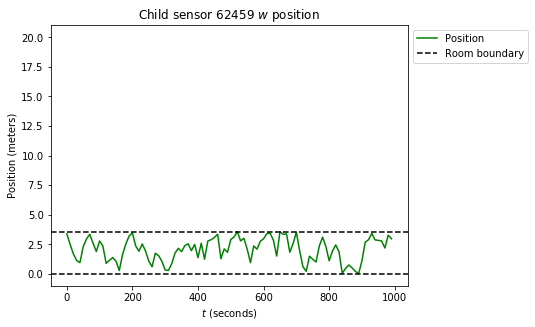

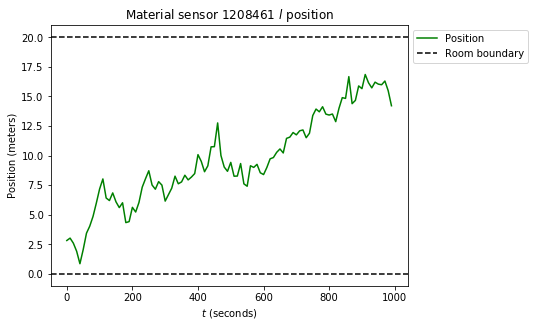

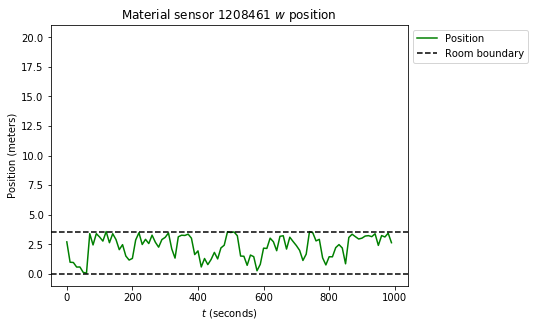

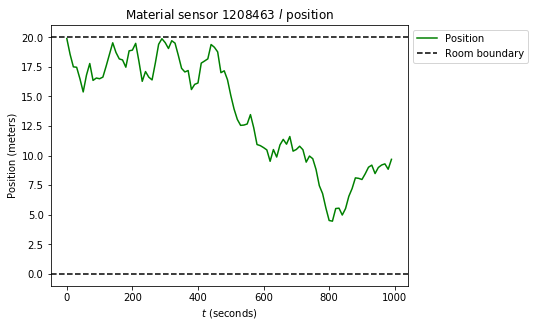

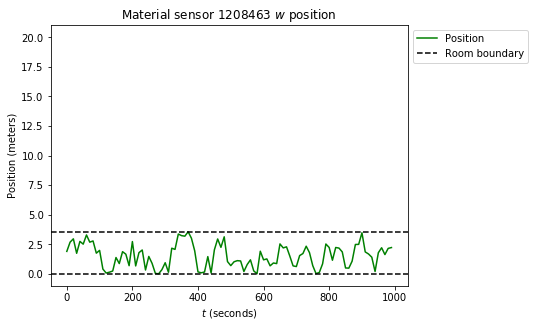

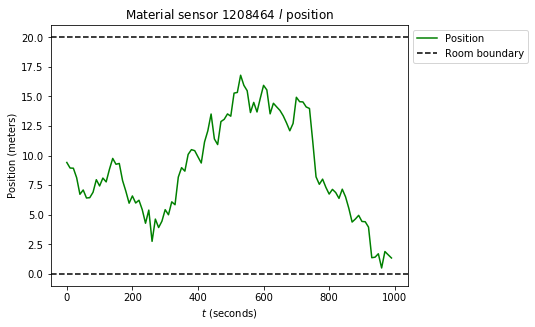

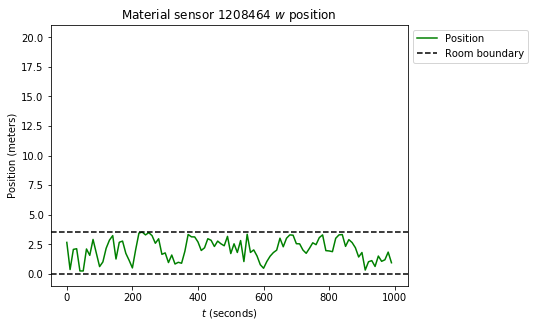

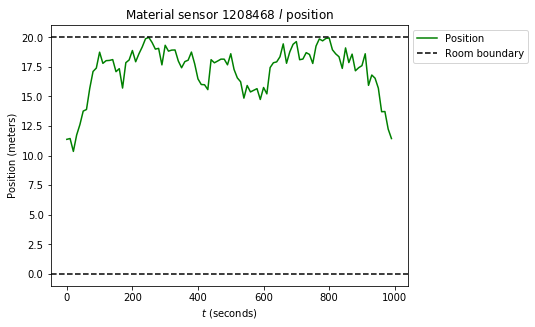

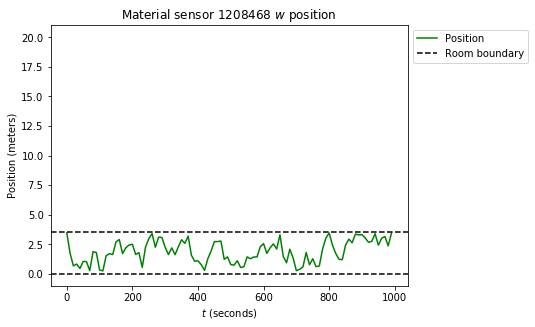

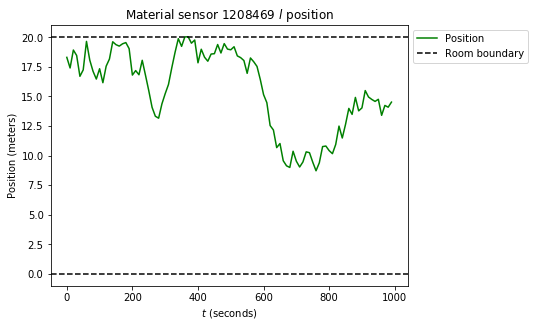

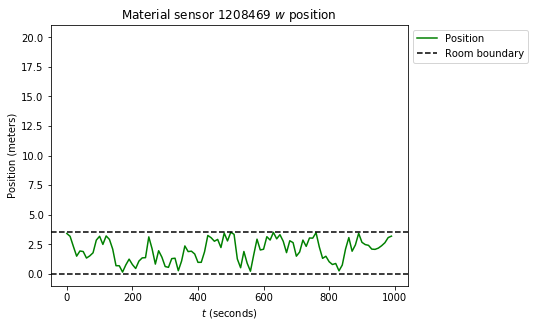

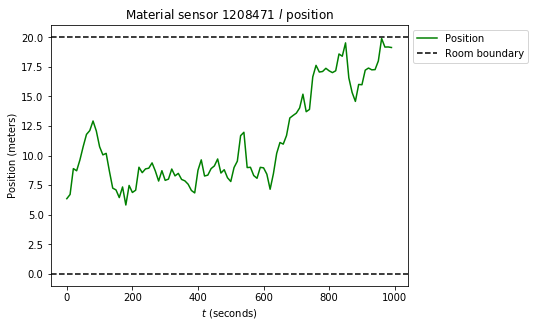

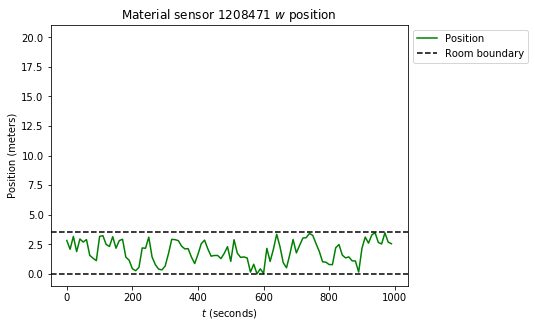

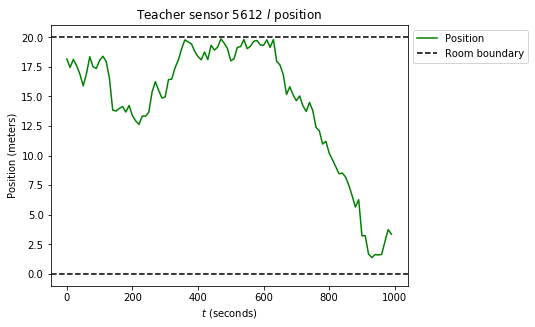

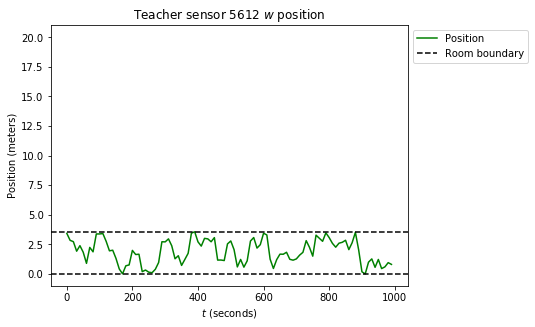

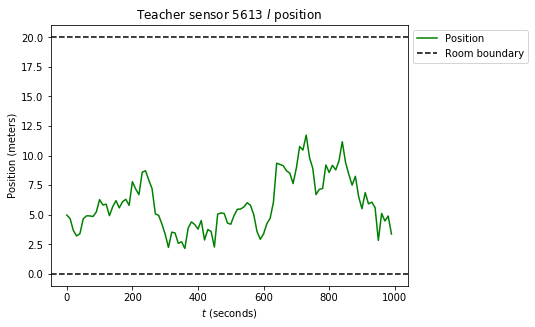

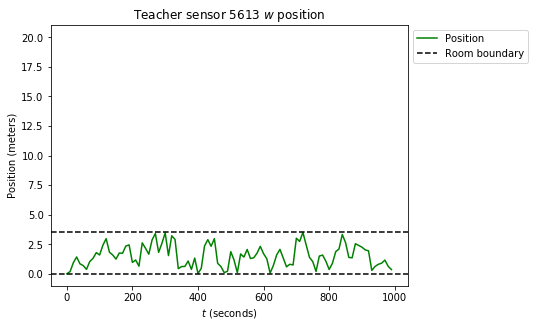

In [144]:
for x_var_index in range(num_x_continuous_vars):
    plt.plot(t, x_continuous_t[:, x_var_index], 'g-', label='Position')
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.plot
    plt.xlabel('$t$ (seconds)')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the measured ping statuses against the distance between the sensors. We should see more missed pings for larger distances, but with a lot of noise.

In [145]:
distances_t = distances(sensor_positions(x_continuous_t))

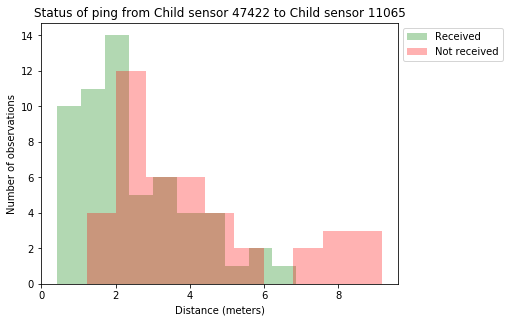

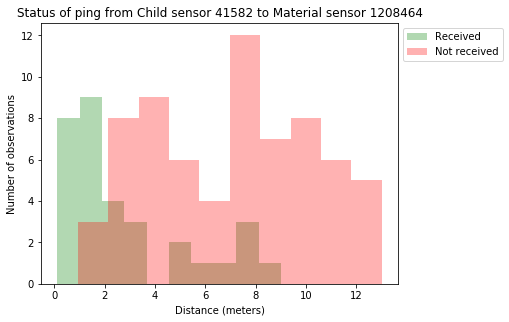

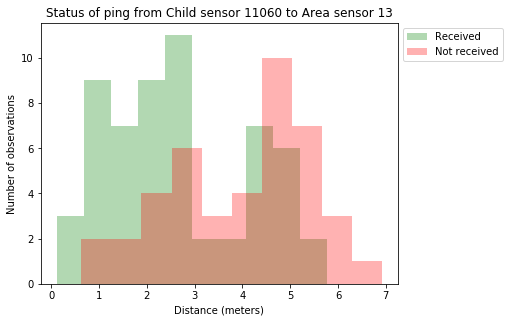

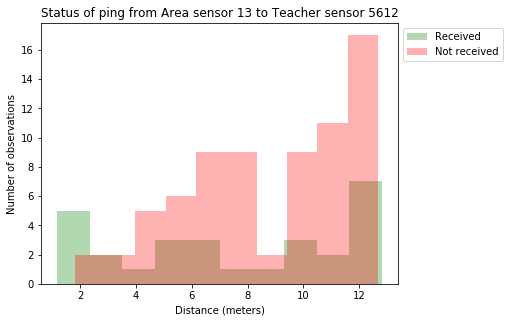

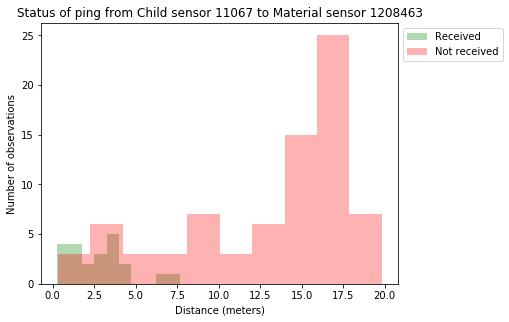

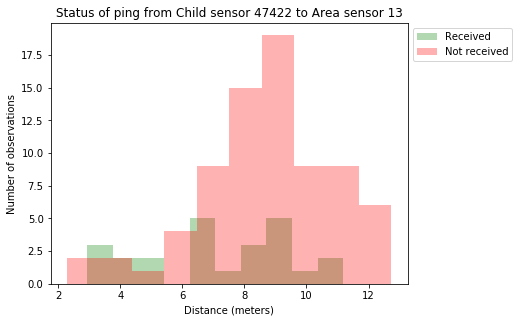

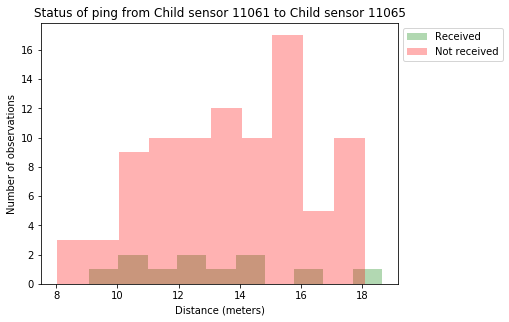

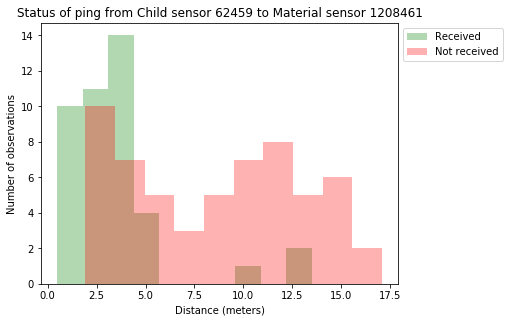

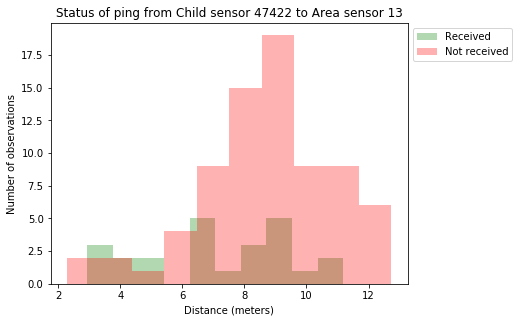

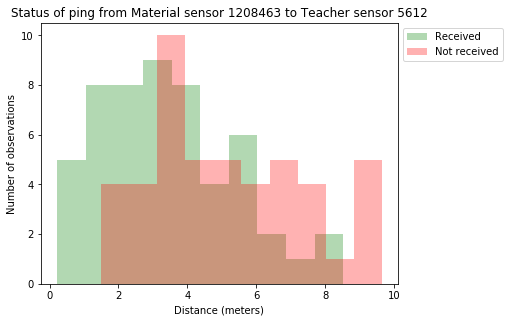

In [146]:
for y_discrete_var_index in np.random.choice(range(num_y_discrete_vars), size=10):
    plt.hist(distances_t[y_discrete_t[:,y_discrete_var_index] == 0, y_discrete_var_index],
            color='green',
            alpha=0.3,
            label=ping_status_names[0])
    plt.hist(distances_t[y_discrete_t[:,y_discrete_var_index] == 1, y_discrete_var_index],
            color='red',
            alpha=0.3,
            label=ping_status_names[1])
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of observations')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the measured RSSI of the received pings versus the distance between the sensors. We should see a wide range of RSSI readings at each distance, but with a mean value that falls off with distance and a hard cut-off at -82 dB.

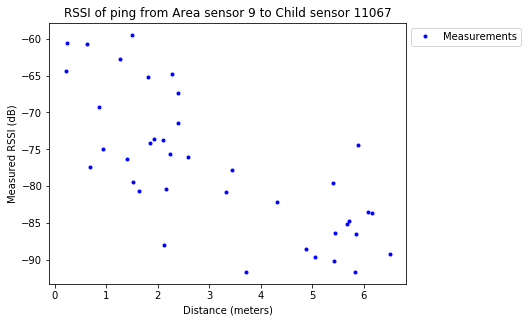

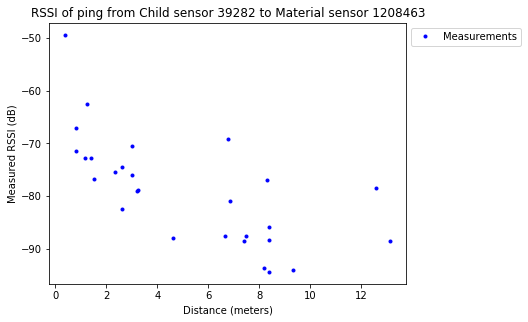

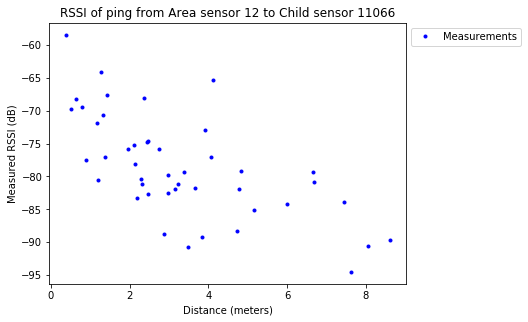

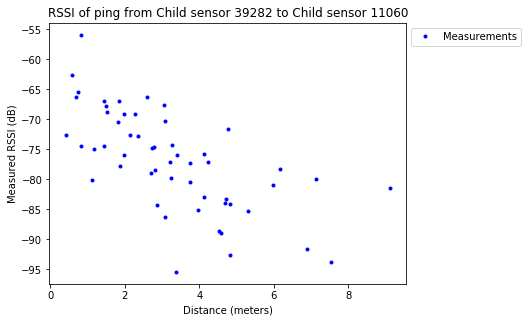

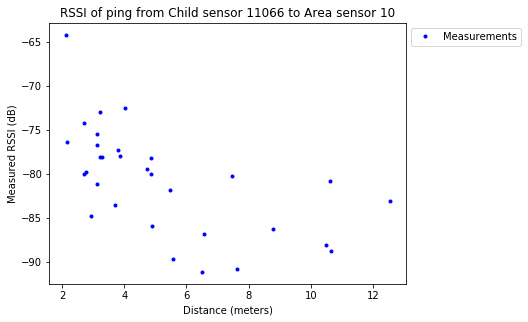

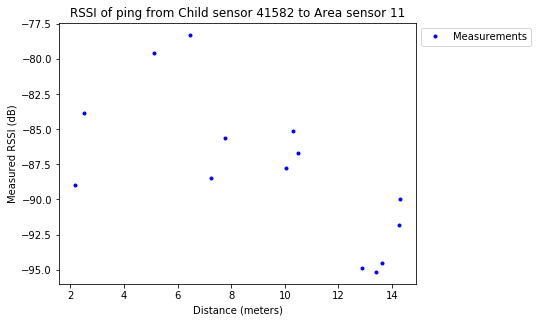

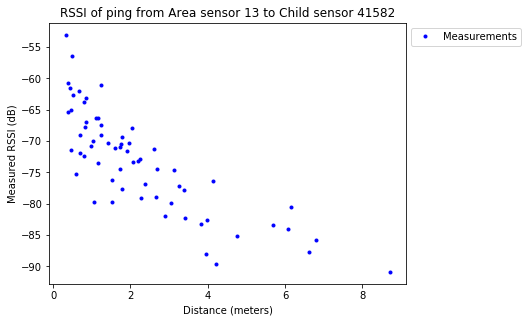

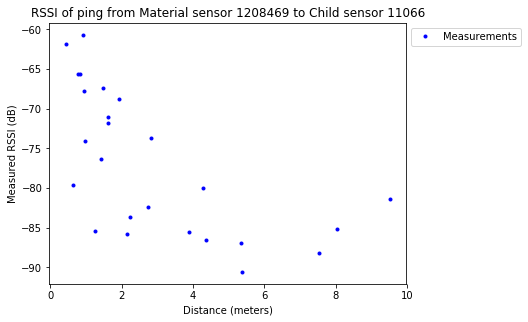

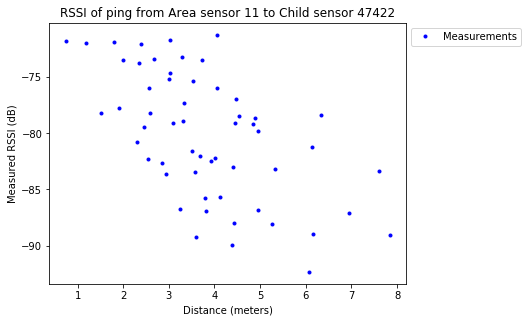

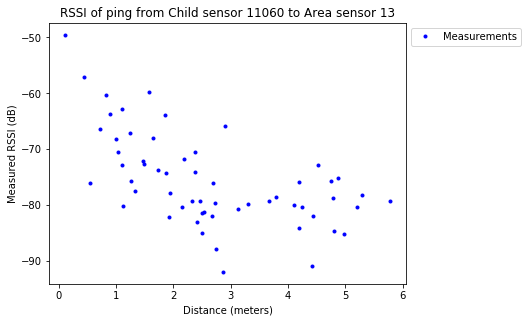

In [147]:
for y_continuous_var_index in np.random.choice(range(num_y_continuous_vars), size=10):
    plt.plot(distances_t[y_discrete_t[:,y_continuous_var_index] == 0, y_continuous_var_index],
             y_continuous_t[y_discrete_t[:,y_continuous_var_index] == 0, y_continuous_var_index],
             'b.',
            label='Measurements')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Measured RSSI (dB)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the simulated data using a particle filter

Set the number of particles and initialize variables.

In [148]:
num_particles = 10000
particle_discrete_values = np.zeros((num_timesteps, num_particles, num_x_discrete_vars), dtype = 'int')
particle_continuous_values = np.zeros((num_timesteps, num_particles, num_x_continuous_vars), dtype = 'float')
log_particle_weights = np.zeros((num_timesteps, num_particles), dtype = 'float')
sampled_particle_indices = np.zeros((num_timesteps, num_particles), dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [149]:
time_start = time.clock()
particle_discrete_values[0], particle_continuous_values[0] = x_initial_sample(num_particles)
log_particle_weights[0] = log_f_y_bar_x(particle_discrete_values[0],
                                        particle_continuous_values[0],
                                        np.tile(y_discrete_t[0], (num_particles,1)),
                                        np.tile(y_continuous_t[0], (num_particles,1)))
log_particle_weights[0] = log_particle_weights[0] - misc.logsumexp(log_particle_weights[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 2.06647216339


Calculate the particles for all times $t>0$.

In [150]:
sys.stdout.write('t_index =')
sys.stdout.flush()
time_start = time.clock()
for t_index in range(1, num_timesteps):
    sys.stdout.write(' {}'.format(t_index))
    sys.stdout.flush()
    sampled_particle_indices[t_index - 1] = np.random.choice(num_particles,
                                                             size=num_particles,
                                                             p=np.exp(log_particle_weights[t_index - 1]))
    particle_discrete_values[t_index], particle_continuous_values[t_index] = x_bar_x_prev_sample(particle_discrete_values[t_index - 1,
                                                                                                                          sampled_particle_indices[t_index - 1]],
                                                                                                 particle_continuous_values[t_index - 1,
                                                                                                                            sampled_particle_indices[t_index - 1]])
    log_particle_weights[t_index] = log_f_y_bar_x(particle_discrete_values[t_index],
                                                  particle_continuous_values[t_index],
                                                  np.tile(y_discrete_t[t_index], (num_particles,1)),
                                                  np.tile(y_continuous_t[t_index], (num_particles,1)))
    log_particle_weights[t_index] = log_particle_weights[t_index]- misc.logsumexp(log_particle_weights[t_index])
print'\nTime elapsed = {}'.format(time.clock()-time_start)

t_index = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99
Time elapsed = 205.513809932


Calculate and plot the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [ ]:
max_weights = np.max(np.exp(log_particle_weights), axis=1)

In [ ]:
plt.plot(t, max_weights)
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()

Calculate and plot the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [ ]:
num_sampled_particles = np.array([len(np.unique(sampled_particle_indices[t_index])) for t_index in range(num_timesteps)])

In [ ]:
plt.plot(t[:-1], num_sampled_particles[:-1])
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()

Calculate the sample means and sample standard deviations of continuous $\mathbf{X}$ variables for the particles at each time $t$.

In [ ]:
x_continuous_mean_particle = np.average(
    particle_continuous_values, 
    axis=1, 
    weights=np.repeat(np.exp(log_particle_weights), num_x_continuous_vars).reshape((num_timesteps, num_particles, num_x_continuous_vars))
)

In [ ]:
x_continuous_squared_mean_particle = np.average(
    np.square(particle_continuous_values), 
    axis=1,
    weights=np.repeat(np.exp(log_particle_weights), num_x_continuous_vars).reshape((num_timesteps, num_particles, num_x_continuous_vars))
)

In [ ]:
x_continuous_sd_particle = np.sqrt(np.abs(x_continuous_squared_mean_particle - np.square(x_continuous_mean_particle)))

Plot the sample means of the particles against the actual values of $\mathbf{X}_t$.

In [ ]:
for x_var_index in range(num_x_continuous_vars):
    plt.plot(t, x_continuous_t[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.plot(t, x_continuous_mean_particle[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$ (seconds)')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

In [ ]:
for x_var_index in range(num_x_continuous_vars):
    plt.plot(t, x_continuous_t[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.fill_between(
        t,
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$ (seconds)')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()